# Análisis de Predicción de Churn para Interconnect (Empresa de Telecomunicaciones)

Este notebook contiene el análisis completo de predicción de churn (abandono de clientes) siguiendo la metodología CRISP-DM (Cross-Industry Standard Process for Data Mining).

## a) Business Understanding

### Formulación del Problema

En la empresa **Interconnect**, el equipo de marketing enfrenta un desafío significativo con la pérdida de clientes (churn), lo cual impacta directamente en los ingresos y la rentabilidad. La adquisición de nuevos clientes suele costar de 5 a 25 veces más que retener a los existentes, por lo que identificar clientes con alto riesgo de abandono es crucial para implementar estrategias de retención efectivas.

El equipo de marketing desea anticiparse a las cancelaciones de suscripciones para ofrecer códigos promocionales específicamente a clientes que muestren señales de posible abandono, optimizando así el presupuesto de retención.

Para este proyecto, contamos con cuatro fuentes de datos interconectadas mediante el identificador único `customerID`:

1. **contract.csv** - Detalles del contrato (tipo, duración, método de pago, importe, etc.)
2. **personal.csv** - Datos demográficos y segmentación del cliente
3. **internet.csv** - Servicios de Internet y características técnicas
4. **phone.csv** - Servicios telefónicos y líneas asociadas

**Objetivo principal**: Desarrollar un modelo de machine learning que prediga con precisión qué clientes tienen mayor probabilidad de abandonar el servicio, permitiendo al equipo de marketing dirigir eficientemente los códigos promocionales a aquellos clientes en riesgo de abandono.

### Hipótesis

Basándonos en el conocimiento del dominio de telecomunicaciones y las fuentes de datos disponibles, planteamos las siguientes hipótesis que guiarán nuestra investigación:

1. **H1**: Los clientes con contratos mensuales tienen mayor probabilidad de abandono que aquellos con contratos a largo plazo (verificable mediante `contract.csv`).

2. **H2**: El tiempo de permanencia como cliente está inversamente relacionado con la probabilidad de abandono (clientes más nuevos tienen mayor riesgo), información disponible en `contract.csv`.

3. **H3**: Los clientes con múltiples líneas telefónicas o servicios adicionales (`phone.csv` y `internet.csv`) tienen menor probabilidad de abandono debido al mayor costo de cambio.

4. **H4**: Los clientes con gastos mensuales más altos son más sensibles a la calidad del servicio y tienen mayor probabilidad de abandono si no perciben un valor adecuado (verificable combinando información financiera de `contract.csv`).

5. **H5**: El uso de múltiples servicios de Internet, como streaming y seguridad (`internet.csv`), reduce la probabilidad de abandono por el efecto de "cliente integral".

6. **H6**: Los métodos de pago automáticos (débito bancario) están asociados a menor tasa de abandono debido a la menor fricción en los pagos (información presente en `contract.csv`).

7. **H7**: Existen patrones demográficos significativos (`personal.csv`) que pueden indicar mayor propensión al abandono en ciertos segmentos de clientes.

Estas hipótesis serán evaluadas durante las fases de análisis exploratorio y modelado, utilizando las cuatro fuentes de datos disponibles.

### Key Performance Indicators (KPIs)

Para medir el éxito de nuestro modelo predictivo y las posteriores estrategias de retención basadas en códigos promocionales, definimos los siguientes KPIs:

#### KPIs del modelo:

1. **AUC-ROC**: El área bajo la curva ROC deberá ser superior a 0.85 para considerar el modelo adecuado para implementación.

2. **Recall (Sensibilidad)**: Deberá ser superior al 80%, priorizando la identificación correcta de clientes que abandonarán (minimizando falsos negativos), para garantizar que no se pierdan oportunidades de retención.

3. **Precisión a diferentes umbrales**: Evaluaremos la precisión del modelo en diferentes puntos de corte de probabilidad para optimizar el balance entre recall y precisión según el presupuesto disponible para códigos promocionales.

#### KPIs de negocio (post-implementación):

1. **Efectividad de los códigos promocionales**: Tasa de redención de códigos promocionales de al menos un 30% entre los clientes identificados como de alto riesgo.

2. **Reducción de la tasa de churn**: Disminución de al menos un 20% en la tasa de abandono entre los clientes identificados como de alto riesgo y contactados con promociones.

3. **ROI de las campañas de retención**: Por cada dólar invertido en códigos promocionales dirigidos por el modelo, se espera un retorno de al menos 3 dólares en ingresos preservados.

4. **Eficiencia presupuestaria**: Reducción del 30% en el gasto promocional por cliente retenido al focalizar esfuerzos en segmentos con mayor riesgo de abandono, comparado con campañas masivas anteriores.

Estos KPIs serán monitoreados continuamente para evaluar la efectividad tanto del modelo predictivo como de la estrategia de retención basada en códigos promocionales.

In [152]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import shap
import warnings
from pathlib import Path
import joblib

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Configurar semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [153]:
# Configuración de rutas para estructura del proyecto

# Definir rutas para los directorios del proyecto
base_dir = Path.cwd().parent

# Verificar y crear directorios si no existen
data_dir = base_dir / 'data'
models_dir = base_dir / 'models'
notebooks_dir = base_dir / 'notebooks'

for directory in [data_dir, models_dir, notebooks_dir]:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f"Directorio creado: {directory}")
    else:
        print(f"Directorio existente: {directory}")

print(f"\nEstructura de directorios:\n")
print(f"- Datos: {data_dir}")
print(f"- Modelos: {models_dir}")
print(f"- Notebooks: {notebooks_dir}")

Directorio existente: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\data
Directorio existente: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\models
Directorio existente: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\notebooks

Estructura de directorios:

- Datos: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\data
- Modelos: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\models
- Notebooks: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\notebooks


## b) Data Understanding

En esta sección, realizaremos una exploración inicial de las cuatro fuentes de datos disponibles, elaboraremos un diccionario de datos para entender la estructura y significado de cada variable, y verificaremos los supuestos planteados en nuestras hipótesis.

In [154]:
# Carga de archivos de datos

# Definición de rutas de los archivos
contract_path = data_dir / 'contract.csv'
personal_path = data_dir / 'personal.csv'
internet_path = data_dir / 'internet.csv'
phone_path = data_dir / 'phone.csv'

# Carga de los dataframes
df_contract = pd.read_csv(contract_path)
df_personal = pd.read_csv(personal_path)
df_internet = pd.read_csv(internet_path)
df_phone = pd.read_csv(phone_path)

# Verificación de las dimensiones de cada dataframe
print(f"Dimensiones de contract.csv: {df_contract.shape}")
print(f"Dimensiones de personal.csv: {df_personal.shape}")
print(f"Dimensiones de internet.csv: {df_internet.shape}")
print(f"Dimensiones de phone.csv: {df_phone.shape}")

Dimensiones de contract.csv: (7043, 8)
Dimensiones de personal.csv: (7043, 5)
Dimensiones de internet.csv: (5517, 8)
Dimensiones de phone.csv: (6361, 2)


### Exploración Inicial de los Datos

Vamos a examinar cada uno de los conjuntos de datos para entender su estructura, distribución y posibles problemas de calidad.


Primeras filas de contract.csv:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Descripción estadística de variables numéricas:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Tipos de datos y valores nulos:


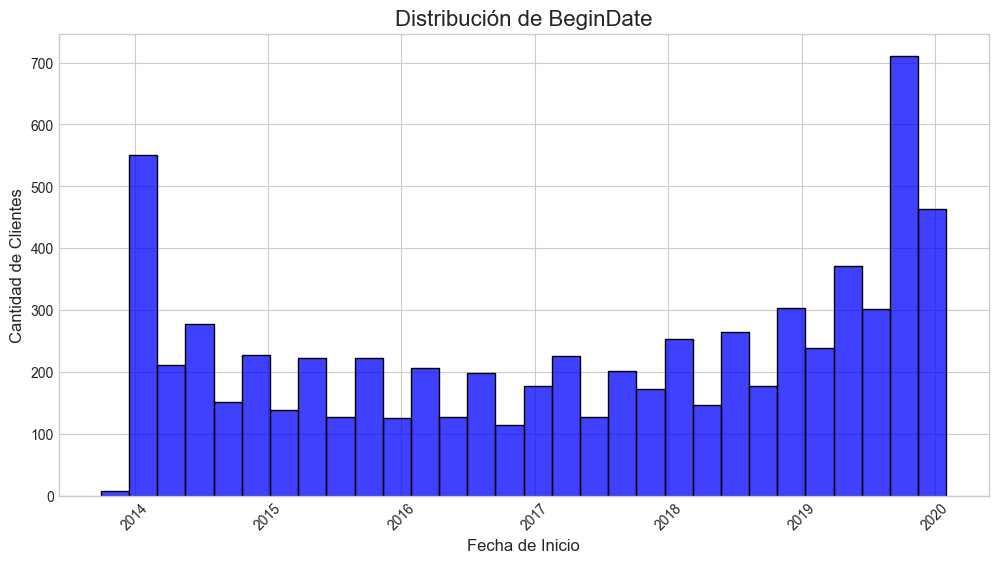


Distribución de valores en variables categóricas:

Distribución de EndDate:


,count
EndDate,
No,5174
2019-11-01 00:00:00,485
2019-12-01 00:00:00,466
2020-01-01 00:00:00,460
2019-10-01 00:00:00,458



Distribución de Type:


,count
Type,
Month-to-month,3875
Two year,1695
One year,1473



Distribución de PaperlessBilling:


,count
PaperlessBilling,
Yes,4171
No,2872



Distribución de PaymentMethod:


,count
PaymentMethod,
Electronic check,2365
Mailed check,1612
Bank transfer (automatic),1544
Credit card (automatic),1522



Distribución de TotalCharges:


,count
TotalCharges,
,11
20.2,11
19.75,9
20.05,8
19.9,8
19.65,8
45.3,7
19.55,7
20.15,6


In [155]:
# Exploración del conjunto de datos de contratos
print("\nPrimeras filas de contract.csv:")
display(df_contract.head())

print("\nDescripción estadística de variables numéricas:")
display(df_contract.describe())

print("\nTipos de datos y valores nulos:")
# Convertimos la columna BeginDate a formato datetime para análisis
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], errors='coerce')

# Creamos un histograma para visualizar la distribución de las fechas de inicio
plt.figure(figsize=(12, 6))
sns.histplot(df_contract['BeginDate'], bins=30, kde=False, color='blue')
plt.title('Distribución de BeginDate', fontsize=16)
plt.xlabel('Fecha de Inicio', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("\nDistribución de valores en variables categóricas:")
for col in df_contract.select_dtypes(include=['object']).columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        display(df_contract[col].value_counts().to_frame().style.background_gradient())

In [156]:
# Exploración del conjunto de datos personales
print("\nPrimeras filas de personal.csv:")
display(df_personal.head())

print("\nDescripción estadística de variables numéricas:")
display(df_personal.describe())

print("\nTipos de datos y valores nulos:")
display(pd.DataFrame({
    'Tipo': df_personal.dtypes,
    'Valores Nulos': df_personal.isnull().sum(),
    '% Valores Nulos': (df_personal.isnull().sum() / len(df_personal)) * 100
}))

print("\nDistribución de valores en variables categóricas:")
for col in df_personal.select_dtypes(include=['object']).columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        display(df_personal[col].value_counts().to_frame().style.background_gradient())


Primeras filas de personal.csv:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Descripción estadística de variables numéricas:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Tipos de datos y valores nulos:


,Tipo,Valores Nulos,% Valores Nulos
customerID,object,0,0.0
gender,object,0,0.0
SeniorCitizen,int64,0,0.0
Partner,object,0,0.0
Dependents,object,0,0.0



Distribución de valores en variables categóricas:

Distribución de gender:


,count
gender,
Male,3555
Female,3488



Distribución de Partner:


,count
Partner,
No,3641
Yes,3402



Distribución de Dependents:


,count
Dependents,
No,4933
Yes,2110


In [157]:
# Exploración del conjunto de datos de internet
print("\nPrimeras filas de internet.csv:")
display(df_internet.head())

print("\nTipos de datos y valores nulos:")
display(pd.DataFrame({
    'Tipo': df_internet.dtypes,
    'Valores Nulos': df_internet.isnull().sum(),
    '% Valores Nulos': (df_internet.isnull().sum() / len(df_internet)) * 100
}))

print("\nDistribución de valores en variables categóricas:")
for col in df_internet.select_dtypes(include=['object']).columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        display(df_internet[col].value_counts().to_frame().style.background_gradient())


Primeras filas de internet.csv:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Tipos de datos y valores nulos:


,Tipo,Valores Nulos,% Valores Nulos
customerID,object,0,0.0
InternetService,object,0,0.0
OnlineSecurity,object,0,0.0
OnlineBackup,object,0,0.0
DeviceProtection,object,0,0.0
TechSupport,object,0,0.0
StreamingTV,object,0,0.0
StreamingMovies,object,0,0.0



Distribución de valores en variables categóricas:

Distribución de InternetService:


,count
InternetService,
Fiber optic,3096
DSL,2421



Distribución de OnlineSecurity:


,count
OnlineSecurity,
No,3498
Yes,2019



Distribución de OnlineBackup:


,count
OnlineBackup,
No,3088
Yes,2429



Distribución de DeviceProtection:


,count
DeviceProtection,
No,3095
Yes,2422



Distribución de TechSupport:


,count
TechSupport,
No,3473
Yes,2044



Distribución de StreamingTV:


,count
StreamingTV,
No,2810
Yes,2707



Distribución de StreamingMovies:


,count
StreamingMovies,
No,2785
Yes,2732


In [158]:
# Exploración del conjunto de datos de teléfono
print("\nPrimeras filas de phone.csv:")
display(df_phone.head())

print("\nTipos de datos y valores nulos:")
display(pd.DataFrame({
    'Tipo': df_phone.dtypes,
    'Valores Nulos': df_phone.isnull().sum(),
    '% Valores Nulos': (df_phone.isnull().sum() / len(df_phone)) * 100
}))

print("\nDistribución de valores en variables categóricas:")
for col in df_phone.select_dtypes(include=['object']).columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        display(df_phone[col].value_counts().to_frame().style.background_gradient())


Primeras filas de phone.csv:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Tipos de datos y valores nulos:


,Tipo,Valores Nulos,% Valores Nulos
customerID,object,0,0.0
MultipleLines,object,0,0.0



Distribución de valores en variables categóricas:

Distribución de MultipleLines:


,count
MultipleLines,
No,3390
Yes,2971


### Diccionario de Datos

A continuación, elaboramos un diccionario de datos detallado para comprender el significado y las características de cada variable en los conjuntos de datos.

#### Conjunto de Datos: contract.csv

| Variable | Descripción | Tipo | Valores Posibles |
|----------|-------------|------|------------------|
| customerID | Identificador único del cliente | Categórico | Alfanumérico |
| tenure | Tiempo como cliente en meses | Numérico | Entero positivo |
| Contract | Tipo de contrato del cliente | Categórico | Month-to-month, One year, Two year |
| PaperlessBilling | Si el cliente tiene facturación sin papel | Categórico | Yes, No |
| PaymentMethod | Método de pago utilizado | Categórico | Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic) |
| MonthlyCharges | Cargo mensual en dólares | Numérico | Decimal positivo |
| TotalCharges | Cargo total acumulado en dólares | Numérico | Decimal positivo |
| Churn | Si el cliente ha abandonado el servicio | Categórico | Yes, No |

#### Conjunto de Datos: personal.csv

| Variable | Descripción | Tipo | Valores Posibles |
|----------|-------------|------|------------------|
| customerID | Identificador único del cliente | Categórico | Alfanumérico |
| gender | Género del cliente | Categórico | Male, Female |
| SeniorCitizen | Si el cliente es adulto mayor | Numérico | 0 (No), 1 (Yes) |
| Partner | Si el cliente tiene pareja | Categórico | Yes, No |
| Dependents | Si el cliente tiene dependientes | Categórico | Yes, No |

#### Conjunto de Datos: internet.csv

| Variable | Descripción | Tipo | Valores Posibles |
|----------|-------------|------|------------------|
| customerID | Identificador único del cliente | Categórico | Alfanumérico |
| InternetService | Tipo de servicio de internet | Categórico | DSL, Fiber optic, No |
| OnlineSecurity | Si tiene servicio de seguridad en línea | Categórico | Yes, No, No internet service |
| OnlineBackup | Si tiene servicio de respaldo en línea | Categórico | Yes, No, No internet service |
| DeviceProtection | Si tiene protección de dispositivos | Categórico | Yes, No, No internet service |
| TechSupport | Si tiene soporte técnico | Categórico | Yes, No, No internet service |
| StreamingTV | Si tiene servicio de streaming de TV | Categórico | Yes, No, No internet service |
| StreamingMovies | Si tiene servicio de streaming de películas | Categórico | Yes, No, No internet service |

#### Conjunto de Datos: phone.csv

| Variable | Descripción | Tipo | Valores Posibles |
|----------|-------------|------|------------------|
| customerID | Identificador único del cliente | Categórico | Alfanumérico |
| PhoneService | Si el cliente tiene servicio telefónico | Categórico | Yes, No |
| MultipleLines | Si el cliente tiene múltiples líneas | Categórico | Yes, No, No phone service |

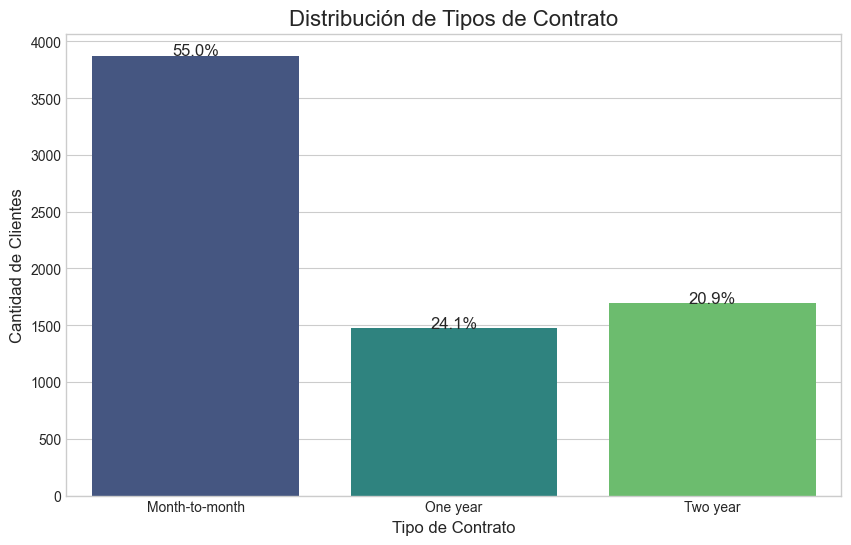

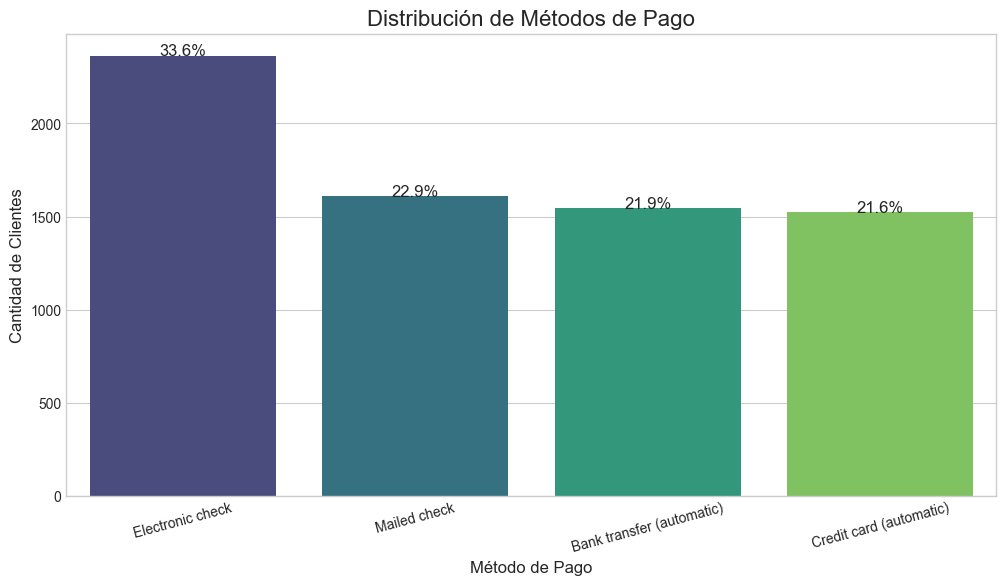

In [159]:
# Análisis exploratorio de patrones en los datos

# Verificamos la distribución de tipos de contrato
contract_distribution = df_contract['Type'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
sns.countplot(x='Type', data=df_contract, palette='viridis')
plt.title('Distribución de Tipos de Contrato', fontsize=16)
plt.xlabel('Tipo de Contrato', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)

# Añadir porcentajes en las barras
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{contract_distribution.iloc[i]:.1f}%',
            ha="center", fontsize=12)

plt.show()

# Verificamos la distribución de métodos de pago
payment_distribution = df_contract['PaymentMethod'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 6))
sns.countplot(x='PaymentMethod', data=df_contract, palette='viridis')
plt.title('Distribución de Métodos de Pago', fontsize=16)
plt.xlabel('Método de Pago', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.xticks(rotation=15)

# Añadir porcentajes en las barras
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{payment_distribution.iloc[i]:.1f}%',
            ha="center", fontsize=12)

plt.show()

### Verificación de Supuestos e Hipótesis

A continuación, realizaremos un análisis exploratorio para verificar las hipótesis planteadas anteriormente. Primero, necesitamos unificar los datos para tener una visión integral de los clientes.

In [160]:
# Unimos los datasets para análisis integral
df_merged = df_contract.merge(df_personal, on='customerID', how='left')
df_merged = df_merged.merge(df_internet, on='customerID', how='left')
df_merged = df_merged.merge(df_phone, on='customerID', how='left')

print(f"Dimensiones del dataset unificado: {df_merged.shape}")
print("\nPrimeras filas del dataset unificado:")
display(df_merged.head())

Dimensiones del dataset unificado: (7043, 20)

Primeras filas del dataset unificado:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## c) Data Preparation

En esta sección realizaremos el proceso de preparación de datos, que incluye la unificación de fuentes, limpieza de datos, imputación de valores faltantes y generación de variables derivadas mediante ingeniería de features. Este proceso es fundamental para optimizar el rendimiento de los modelos predictivos que desarrollaremos posteriormente.

### Unificación de Fuentes de Datos

El primer paso consiste en integrar las cuatro fuentes de datos (contrato, personal, internet y teléfono) en un único conjunto de datos consolidado, utilizando el identificador `customerID` como clave de unión.

In [161]:
# Verificamos la estructura del dataset unificado
print("Columnas en el dataset unificado:")
print(df_merged.columns.tolist())

# Verificamos la consistencia de la unificación
print(f"\nCantidad de registros en el dataset original de contratos: {df_contract.shape[0]}")
print(f"Cantidad de registros en el dataset unificado: {df_merged.shape[0]}")

# Verificamos si hay duplicados en customerID
print(f"\nCustomerIDs únicos en contract.csv: {df_contract['customerID'].nunique()}")
print(f"CustomerIDs únicos en el dataset unificado: {df_merged['customerID'].nunique()}")

# Verificamos si hay valores faltantes después de la unión
missing_values = df_merged.isnull().sum()
print("\nValores faltantes por columna:")
display(pd.DataFrame({
    'Valores Faltantes': missing_values,
    '% Valores Faltantes': (missing_values / len(df_merged)) * 100
}).loc[missing_values > 0])

Columnas en el dataset unificado:
['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

Cantidad de registros en el dataset original de contratos: 7043
Cantidad de registros en el dataset unificado: 7043

CustomerIDs únicos en contract.csv: 7043
CustomerIDs únicos en el dataset unificado: 7043

Valores faltantes por columna:


,Valores Faltantes,% Valores Faltantes
InternetService,1526,21.666903
OnlineSecurity,1526,21.666903
OnlineBackup,1526,21.666903
DeviceProtection,1526,21.666903
TechSupport,1526,21.666903
StreamingTV,1526,21.666903
StreamingMovies,1526,21.666903
MultipleLines,682,9.683374


### Limpieza de Datos e Imputación

Procederemos a limpiar los datos, manejar los valores faltantes y corregir posibles inconsistencias en el conjunto de datos unificado.

Tipos de datos actuales:


customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges                object
gender                      object
SeniorCitizen                int64
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
dtype: object


Calculada la columna 'tenure' en meses a partir de BeginDate y EndDate
Estadísticas de la nueva columna tenure:


count    7043.000000
mean       67.904018
std        37.922141
min         1.000000
25%        49.000000
50%        70.000000
75%       101.000000
max       121.000000
Name: tenure, dtype: float64


Convertidos valores de TotalCharges a numéricos
Valores NaN en TotalCharges después de la conversión: 11
Columna de permanencia encontrada: tenure
Columna de cargos mensuales encontrada: MonthlyCharges
Validando consistencia entre tenure x MonthlyCharges vs TotalCharges


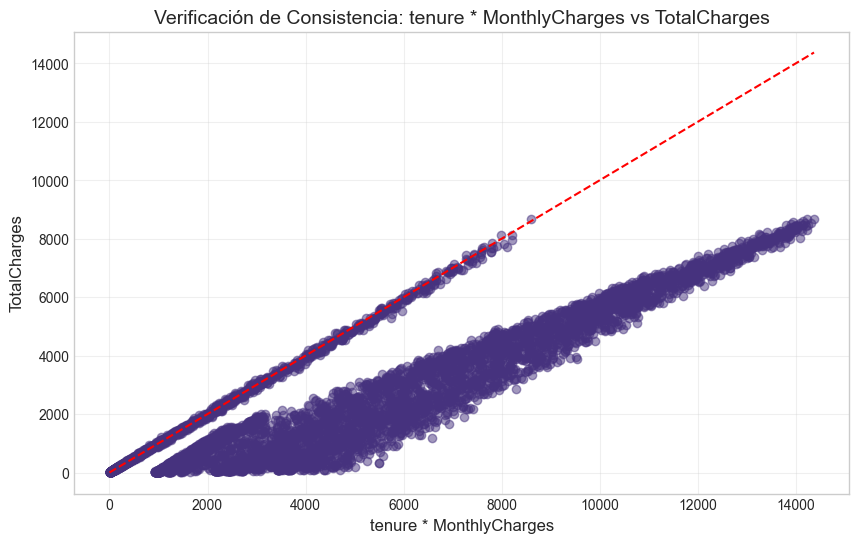

Correlación entre tenure*MonthlyCharges y TotalCharges: 0.9210


In [162]:
# Inspeccionamos los tipos de datos actuales
print("Tipos de datos actuales:")
display(df_merged.dtypes)

# Convertimos las fechas a datetime para calcular tenure
df_merged['BeginDate'] = pd.to_datetime(df_merged['BeginDate'], errors='coerce')
df_merged['EndDate'] = pd.to_datetime(df_merged['EndDate'], errors='coerce')

# Crear la variable objetivo 'Churn' según si el cliente terminó el contrato
df_merged['Churn'] = df_merged['EndDate'].apply(
    lambda x: 'Yes' if pd.notnull(x) else 'No'
)

# Calculamos la tenure (tiempo como cliente) en meses a partir de las fechas
today = pd.Timestamp('2023-12-31')  # Fecha de referencia para cuando no hay EndDate
df_merged['tenure'] = df_merged.apply(
    lambda x: ((x['EndDate'] if pd.notna(x['EndDate']) else today) - x['BeginDate']).days / 30 
    if pd.notna(x['BeginDate']) else 0, 
    axis=1
)
df_merged['tenure'] = df_merged['tenure'].round().astype('float')

print("\nCalculada la columna 'tenure' en meses a partir de BeginDate y EndDate")
print(f"Estadísticas de la nueva columna tenure:")
display(df_merged['tenure'].describe())

# Convertimos TotalCharges a numérico (si es necesario)
if df_merged['TotalCharges'].dtype == 'object':
    # Reemplazamos espacios en blanco con NaN para manejarlos adecuadamente
    df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')
    print("\nConvertidos valores de TotalCharges a numéricos")
    print(f"Valores NaN en TotalCharges después de la conversión: {df_merged['TotalCharges'].isna().sum()}")

# Verificamos qué columnas están disponibles para la validación de consistencia
# Verificar si existen las columnas necesarias para la consistencia
required_columns = ['TotalCharges', 'tenure']
available_tenure = 'tenure'  # Ahora tenemos esta columna
available_monthly = None

# Buscar columnas relacionadas con permanencia (tenure)
for col in df_merged.columns:
    if 'tenure' in col.lower() or 'tiempo' in col.lower() or 'permanencia' in col.lower():
        available_tenure = col
        print(f"Columna de permanencia encontrada: {col}")
        break

# Buscar columnas relacionadas con cargos mensuales
for col in df_merged.columns:
    if 'monthly' in col.lower() or 'mensual' in col.lower() or 'charges' in col.lower() or 'cargo' in col.lower():
        available_monthly = col
        print(f"Columna de cargos mensuales encontrada: {col}")
        break

# Si encontramos las columnas necesarias, procedemos con la validación
if 'TotalCharges' in df_merged.columns and available_tenure and available_monthly:
    print(f"Validando consistencia entre {available_tenure} x {available_monthly} vs TotalCharges")
    plt.figure(figsize=(10, 6))
    plt.scatter(df_merged[available_tenure] * df_merged[available_monthly], df_merged['TotalCharges'], alpha=0.5)
    plt.plot([0, df_merged[available_tenure].max() * df_merged[available_monthly].max()], 
             [0, df_merged[available_tenure].max() * df_merged[available_monthly].max()], 
             'r--')
    plt.xlabel(f'{available_tenure} * {available_monthly}', fontsize=12)
    plt.ylabel('TotalCharges', fontsize=12)
    plt.title(f'Verificación de Consistencia: {available_tenure} * {available_monthly} vs TotalCharges', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No se encontraron las columnas necesarias para la validación de consistencia.")
    print("Columnas disponibles en el dataframe:")
    for col in df_merged.columns:
        print(f"- {col}")

# Calculamos la correlación para verificar la relación (si las columnas están disponibles)
if 'TotalCharges' in df_merged.columns and available_tenure and available_monthly:
    # Eliminar filas con valores faltantes en las columnas necesarias
    df_valid = df_merged.dropna(subset=['TotalCharges', available_tenure, available_monthly])
    
    # Calcular la correlación
    corr = np.corrcoef(df_valid[available_tenure] * df_valid[available_monthly], df_valid['TotalCharges'])[0, 1]
    print(f"Correlación entre {available_tenure}*{available_monthly} y TotalCharges: {corr:.4f}")
else:
    print("No se pudo calcular la correlación debido a la falta de columnas requeridas.")

In [163]:
# Veamos qué columnas exactamente tenemos en nuestros DataFrames
print("Columnas en df_contract:")
print(df_contract.columns.tolist())

print("\nColumnas en df_merged:")
print(df_merged.columns.tolist())

# Comprobamos los primeros registros para ver los datos
print("\nPrimeras filas de df_contract:")
display(df_contract.head(2))

Columnas en df_contract:
['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Columnas en df_merged:
['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Churn', 'tenure']

Primeras filas de df_contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5


In [164]:
# Imputación de valores faltantes

# Para TotalCharges, imputamos usando tenure * MonthlyCharges para clientes nuevos
if df_merged['TotalCharges'].isna().sum() > 0:
    # Identificamos registros con TotalCharges faltantes
    missing_total = df_merged['TotalCharges'].isna()
    
    # Imputamos usando el producto tenure * MonthlyCharges
    df_merged.loc[missing_total, 'TotalCharges'] = df_merged.loc[missing_total, 'tenure'] * \
                                                  df_merged.loc[missing_total, 'MonthlyCharges']
    
    print(f"Imputados {missing_total.sum()} valores faltantes en TotalCharges")

# Verificamos otras columnas con valores faltantes
remaining_missing = df_merged.isnull().sum()
print("\nValores faltantes restantes por columna:")
display(pd.DataFrame({
    'Valores Faltantes': remaining_missing,
    '% Valores Faltantes': (remaining_missing / len(df_merged)) * 100
}).loc[remaining_missing > 0])

# Verificamos si hay duplicados en el dataset
duplicates = df_merged.duplicated().sum()
print(f"\nRegistros duplicados en el dataset: {duplicates}")

# Si hay duplicados, los eliminamos
if duplicates > 0:
    df_merged = df_merged.drop_duplicates()
    print(f"Eliminados {duplicates} registros duplicados")

Imputados 11 valores faltantes en TotalCharges

Valores faltantes restantes por columna:


,Valores Faltantes,% Valores Faltantes
EndDate,5174,73.463013
InternetService,1526,21.666903
OnlineSecurity,1526,21.666903
OnlineBackup,1526,21.666903
DeviceProtection,1526,21.666903
TechSupport,1526,21.666903
StreamingTV,1526,21.666903
StreamingMovies,1526,21.666903
MultipleLines,682,9.683374



Registros duplicados en el dataset: 0


### Ingeniería de Variables

Crearemos nuevas variables que potencialmente podrían mejorar el poder predictivo de nuestros modelos, incluyendo transformaciones, variables categóricas y numéricas derivadas.

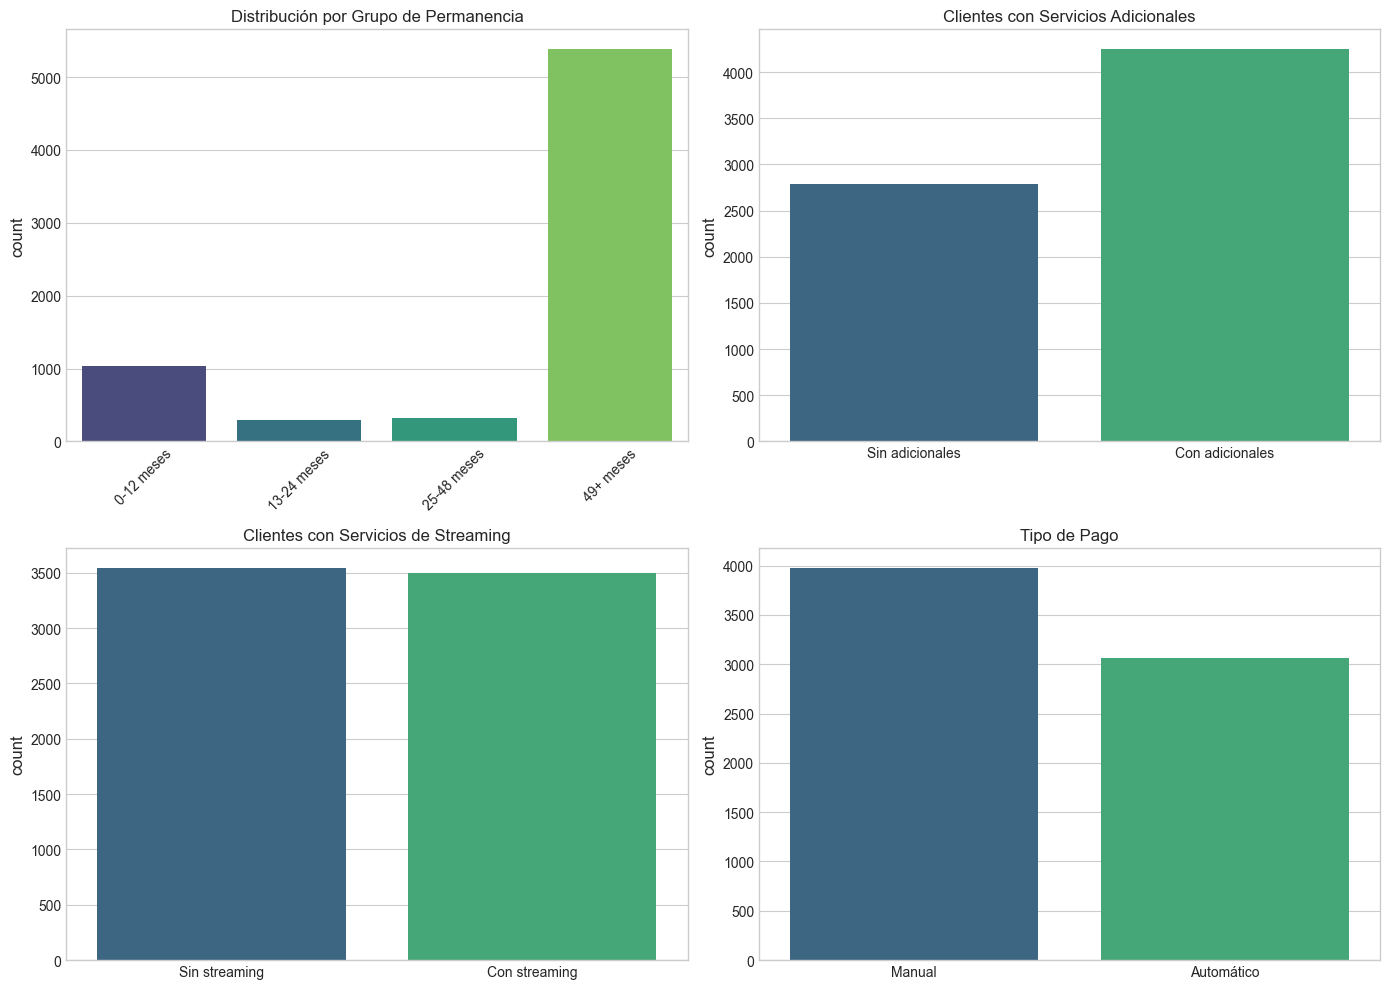

In [165]:
# 1. Creación de variables categóricas derivadas

# Categorización de tenure en grupos 
# (0-12 meses, 13-24 meses, 25-48 meses, 49+ meses)
df_merged['TenureGroup'] = pd.cut(
    df_merged['tenure'],
    bins=[0, 12, 24, 48, float('inf')],
    labels=['0-12 meses', '13-24 meses', '25-48 meses', '49+ meses']
)

# Creamos una variable que indica si el cliente tiene servicios adicionales
df_merged['HasAddOns'] = ((df_merged['OnlineSecurity'] == 'Yes') | 
                         (df_merged['OnlineBackup'] == 'Yes') | 
                         (df_merged['DeviceProtection'] == 'Yes') | 
                         (df_merged['TechSupport'] == 'Yes')).astype(int)

# Creamos una variable que indica si el cliente tiene servicios de streaming
df_merged['HasStreaming'] = ((df_merged['StreamingTV'] == 'Yes') | 
                           (df_merged['StreamingMovies'] == 'Yes')).astype(int)

# Creamos una variable que indica si el cliente tiene algún tipo de protección/seguridad
df_merged['HasProtection'] = ((df_merged['OnlineSecurity'] == 'Yes') | 
                            (df_merged['DeviceProtection'] == 'Yes')).astype(int)

# Variable para métodos de pago automáticos vs manuales
df_merged['AutomaticPayment'] = df_merged['PaymentMethod'].apply(
    lambda x: 1 if ('automatic' in x.lower()) else 0
)

# Mostramos la distribución de las nuevas variables categóricas
plt.figure(figsize=(14, 10))

# TenureGroup
plt.subplot(2, 2, 1)
sns.countplot(x='TenureGroup', data=df_merged, palette='viridis')
plt.title('Distribución por Grupo de Permanencia', fontsize=12)
plt.xticks(rotation=45)
plt.xlabel('')

# HasAddOns
plt.subplot(2, 2, 2)
sns.countplot(x='HasAddOns', data=df_merged, palette='viridis')
plt.title('Clientes con Servicios Adicionales', fontsize=12)
plt.xticks([0, 1], ['Sin adicionales', 'Con adicionales'])
plt.xlabel('')

# HasStreaming
plt.subplot(2, 2, 3)
sns.countplot(x='HasStreaming', data=df_merged, palette='viridis')
plt.title('Clientes con Servicios de Streaming', fontsize=12)
plt.xticks([0, 1], ['Sin streaming', 'Con streaming'])
plt.xlabel('')

# AutomaticPayment
plt.subplot(2, 2, 4)
sns.countplot(x='AutomaticPayment', data=df_merged, palette='viridis')
plt.title('Tipo de Pago', fontsize=12)
plt.xticks([0, 1], ['Manual', 'Automático'])
plt.xlabel('')

plt.tight_layout()
plt.show()

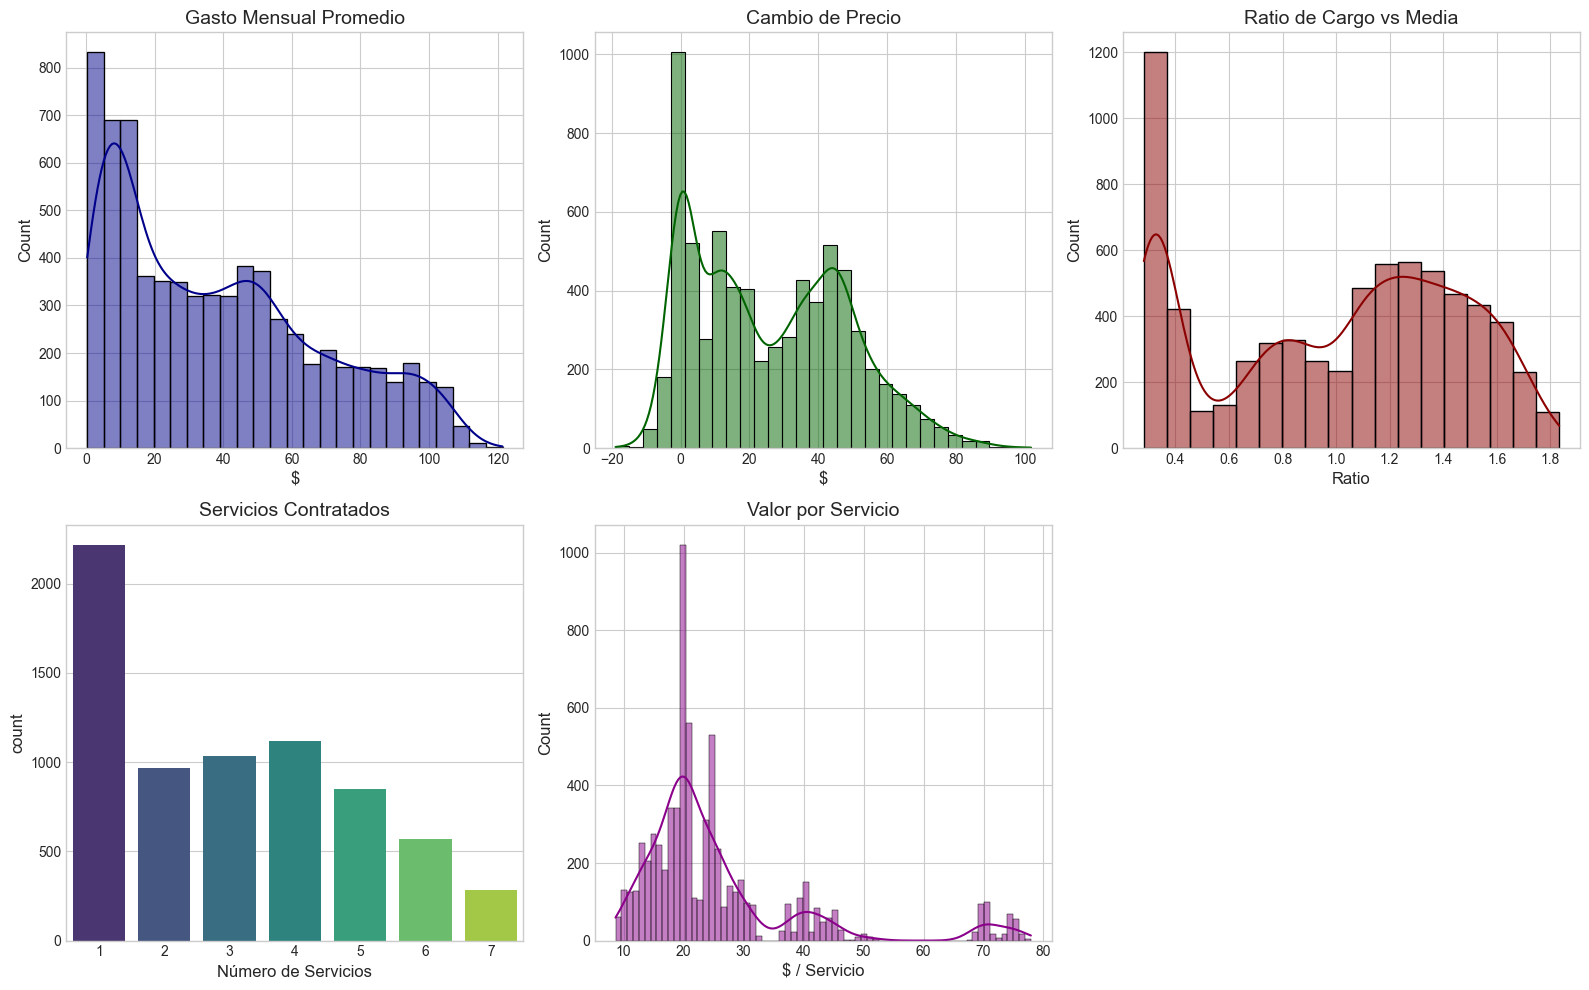

In [166]:
# 2. Creación de variables numéricas derivadas

# 2.0 Derivar indicador de PhoneService a partir de MultipleLines
#    (la columna 'MultipleLines' vale 'No phone service' si no hay servicio)
df_merged['PhoneService'] = df_merged['MultipleLines'].apply(
    lambda x: 'Yes' if x != 'No phone service' else 'No'
)

# 2.1 Gasto promedio mensual total
df_merged['AvgMonthlySpend'] = df_merged.apply(
    lambda x: x['TotalCharges'] / x['tenure'] 
              if x['tenure'] > 0 else x['MonthlyCharges'],
    axis=1
)

# 2.2 Cambio de precio actual vs. histórico
df_merged['PriceChange'] = (
    df_merged['MonthlyCharges'] - df_merged['AvgMonthlySpend']
)

# 2.3 Ratio de cargos vs. media general
df_merged['ChargeRatio'] = (
    df_merged['MonthlyCharges'] / df_merged['MonthlyCharges'].mean()
)

# 2.4 Conteo de servicios contratados
internet_services = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

df_merged['TotalServices'] = (
    df_merged[internet_services]
        .apply(lambda row: sum(row == 'Yes'), axis=1)
    + df_merged['PhoneService'].apply(lambda x: 1 if x == 'Yes' else 0)
)

# 2.5 Valor por servicio
df_merged['ValuePerService'] = df_merged.apply(
    lambda x: x['MonthlyCharges'] / x['TotalServices']
              if x['TotalServices'] > 0 else 0,
    axis=1
)

# 2.6 Visualizar distribuciones
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))

# AvgMonthlySpend
plt.subplot(2, 3, 1)
sns.histplot(df_merged['AvgMonthlySpend'], kde=True, color='darkblue')
plt.title('Gasto Mensual Promedio')
plt.xlabel('$')

# PriceChange
plt.subplot(2, 3, 2)
sns.histplot(df_merged['PriceChange'], kde=True, color='darkgreen')
plt.title('Cambio de Precio')
plt.xlabel('$')

# ChargeRatio
plt.subplot(2, 3, 3)
sns.histplot(df_merged['ChargeRatio'], kde=True, color='darkred')
plt.title('Ratio de Cargo vs Media')
plt.xlabel('Ratio')

# TotalServices
plt.subplot(2, 3, 4)
sns.countplot(x='TotalServices', data=df_merged, palette='viridis')
plt.title('Servicios Contratados')
plt.xlabel('Número de Servicios')

# ValuePerService
plt.subplot(2, 3, 5)
sns.histplot(df_merged['ValuePerService'], kde=True, color='darkmagenta')
plt.title('Valor por Servicio')
plt.xlabel('$ / Servicio')

plt.tight_layout()
plt.show()

### Encoding y Transformación de Variables

Procederemos a transformar las variables categóricas utilizando técnicas de encoding y a escalar las variables numéricas para prepararlas para el modelado.

In [167]:
# 1. Identificación de variables categóricas y numéricas

# Excluimos customerID ya que no aporta valor predictivo y la columna objetivo (Churn)
features = df_merged.columns.drop(['customerID', 'Churn'])

# Identificamos tipos de variables
categorical_cols = df_merged[features].select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_merged[features].select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Variables categóricas: {len(categorical_cols)}")
print(categorical_cols)
print(f"\nVariables numéricas: {len(numerical_cols)}")
print(numerical_cols)

# 2. One-Hot Encoding para variables categóricas

# Creamos un nuevo DataFrame para almacenar las variables transformadas
df_encoded = df_merged.copy()

# Aplicamos One-Hot Encoding a todas las variables categóricas
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True, prefix_sep='_')

print(f"\nDimension del dataframe original: {df_merged.shape}")
print(f"Dimension del dataframe codificado: {df_encoded.shape}")

# Mostramos las primeras columnas resultantes del encoding
print("\nAlgunas de las nuevas columnas codificadas:")
display(df_encoded.iloc[:, -10:].head())

Variables categóricas: 16
['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'TenureGroup', 'PhoneService']

Variables numéricas: 10
['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'tenure', 'AutomaticPayment', 'AvgMonthlySpend', 'PriceChange', 'ChargeRatio', 'TotalServices', 'ValuePerService']

Dimension del dataframe original: (7043, 33)
Dimension del dataframe codificado: (7043, 37)

Algunas de las nuevas columnas codificadas:


,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,TenureGroup_13-24 meses,TenureGroup_25-48 meses,TenureGroup_49+ meses
0,False,True,False,False,False,False,False,False,False,True
1,True,False,True,False,False,False,False,False,False,True
2,True,True,False,False,False,False,False,False,False,False
3,True,False,True,True,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False


Estadísticas de las variables escaladas:


,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,1.697413e-16,1.000071,-1.764372,-0.498531,0.055275,0.872797,1.400231
MonthlyCharges,7043.0,-6.406285e-17,1.000071,-1.545860,-0.972540,0.185733,0.833833,1.794352
TotalCharges,7043.0,-9.811200e-17,1.000071,-0.999453,-0.830191,-0.390918,0.665508,2.826124
AvgMonthlySpend,7043.0,-3.430137e-17,1.000071,-1.264852,-0.902230,-0.178892,0.674941,2.752218
PriceChange,7043.0,-4.237228e-17,1.000071,-2.033631,-0.948040,-0.119814,0.806387,3.400091
ChargeRatio,7043.0,-6.355842e-17,1.000071,-1.545860,-0.972540,0.185733,0.833833,1.794352
ValuePerService,7043.0,4.287671e-17,1.000071,-1.194979,-0.529723,-0.342741,0.137307,3.719047


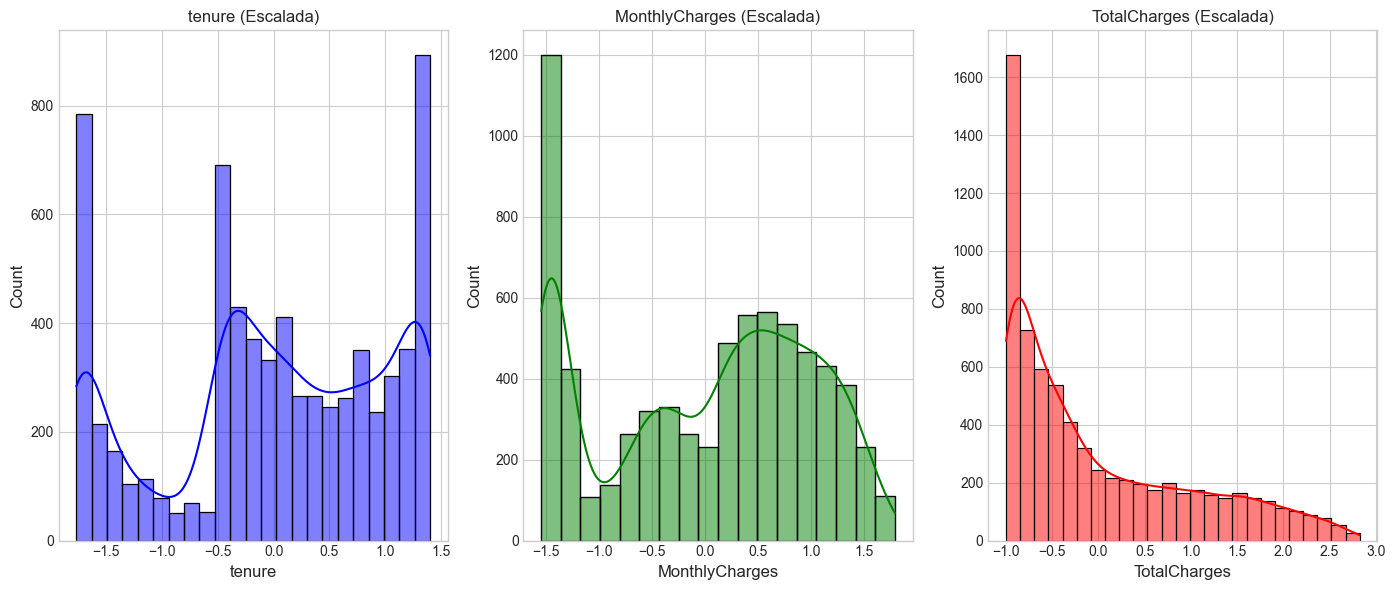

In [168]:
# 3. Escalado de variables numéricas
from sklearn.preprocessing import StandardScaler

# Seleccionamos las columnas numéricas para escalar
numerical_cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 
                          'PriceChange', 'ChargeRatio', 'ValuePerService']

# Creamos un nuevo DataFrame para almacenar las variables escaladas
df_scaled = df_encoded.copy()

# Aplicamos escalado estándar (media=0, desviación=1)
scaler = StandardScaler()
df_scaled[numerical_cols_to_scale] = scaler.fit_transform(df_scaled[numerical_cols_to_scale])

# Mostramos un resumen de las variables escaladas
print("Estadísticas de las variables escaladas:")
display(df_scaled[numerical_cols_to_scale].describe().T)

# Visualizamos algunas de las variables numéricas escaladas
plt.figure(figsize=(14, 6))

# tenure
plt.subplot(1, 3, 1)
sns.histplot(df_scaled['tenure'], kde=True, color='blue')
plt.title('tenure (Escalada)', fontsize=12)

# MonthlyCharges
plt.subplot(1, 3, 2)
sns.histplot(df_scaled['MonthlyCharges'], kde=True, color='green')
plt.title('MonthlyCharges (Escalada)', fontsize=12)

# TotalCharges
plt.subplot(1, 3, 3)
sns.histplot(df_scaled['TotalCharges'], kde=True, color='red')
plt.title('TotalCharges (Escalada)', fontsize=12)

plt.tight_layout()
plt.show()

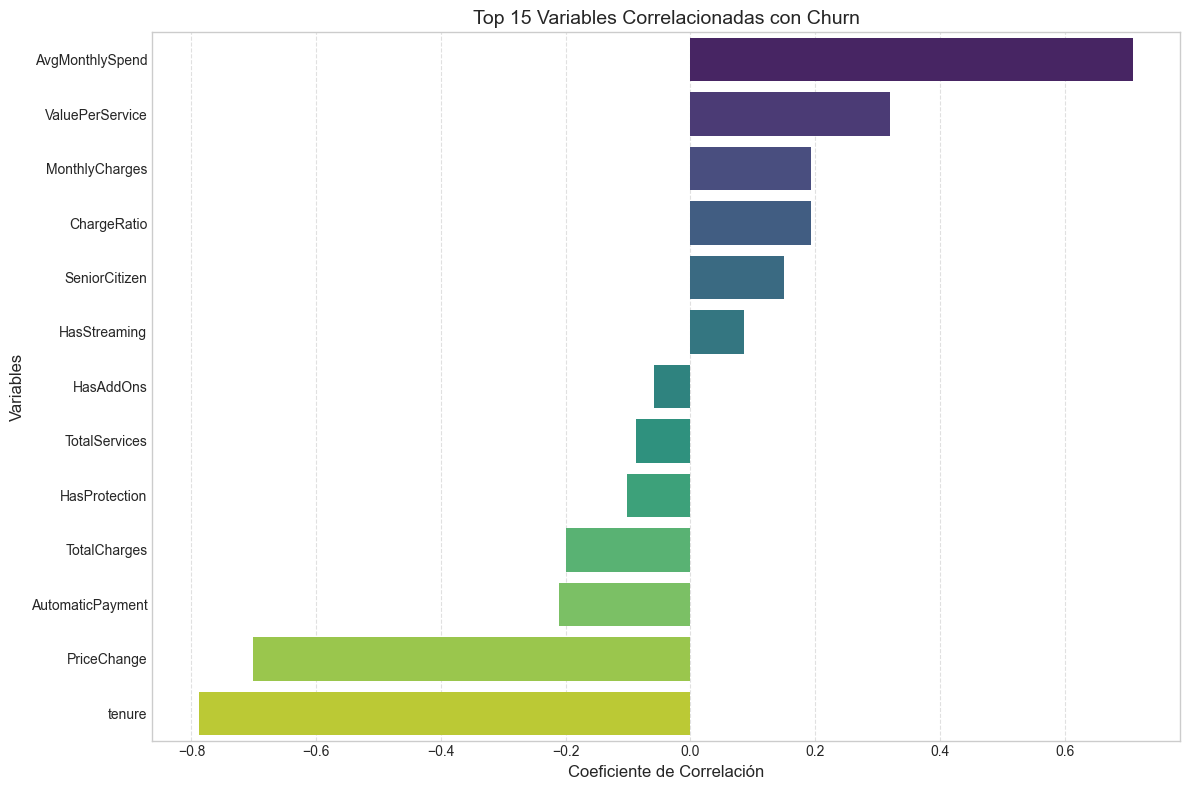

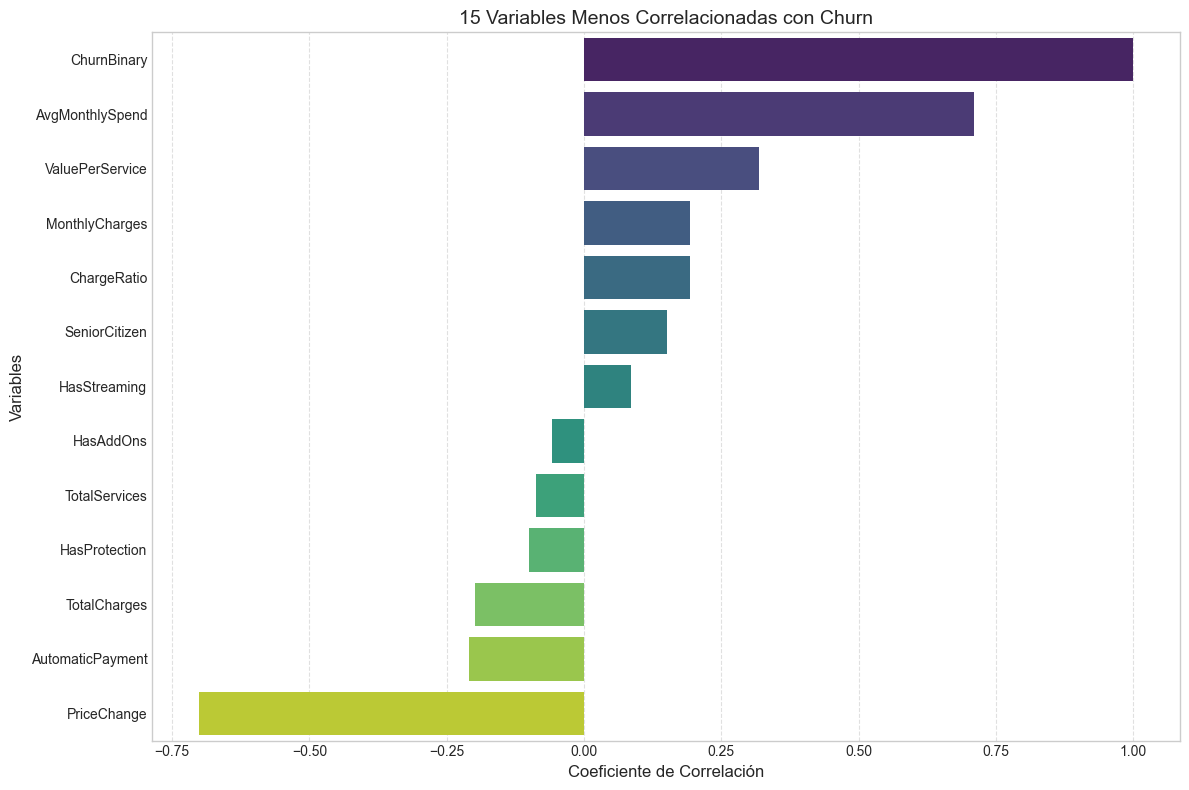

In [169]:
# 4. Análisis de correlación entre variables y target (Churn)

# Convertimos Churn a formato binario (1=Yes, 0=No)
df_scaled['ChurnBinary'] = (df_merged['Churn'] == 'Yes').astype(int)

# Calculamos la correlación con la variable objetivo, excluyendo columnas no numéricas
numeric_df = df_scaled.select_dtypes(include=['float64', 'int64', 'int32'])
churn_corr = numeric_df.corr()['ChurnBinary'].sort_values(ascending=False)

# Visualizamos las 15 variables más correlacionadas con Churn
plt.figure(figsize=(12, 8))
sns.barplot(x=churn_corr.iloc[1:16].values, y=churn_corr.iloc[1:16].index, palette='viridis')
plt.title('Top 15 Variables Correlacionadas con Churn', fontsize=14)
plt.xlabel('Coeficiente de Correlación', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Visualizamos las 15 variables menos correlacionadas con Churn
plt.figure(figsize=(12, 8))
sns.barplot(x=churn_corr.iloc[-16:-1].values, y=churn_corr.iloc[-16:-1].index, palette='viridis')
plt.title('15 Variables Menos Correlacionadas con Churn', fontsize=14)
plt.xlabel('Coeficiente de Correlación', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Preparación Final del Dataset para Modelado

Finalizamos el proceso de preparación de datos dividiendo el conjunto de datos en features (X) y variable objetivo (y), y guardando el dataset procesado para la fase de modelado.

Dimensiones de X: (7043, 36)
Dimensiones de y: (7043,)

Distribución de la variable objetivo:


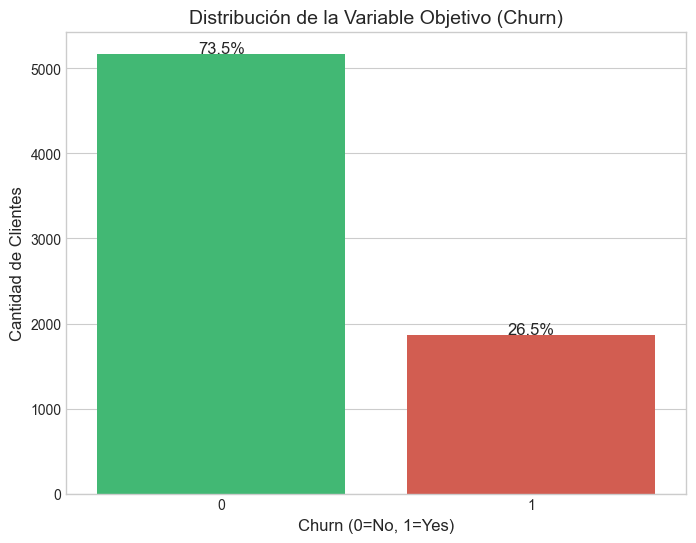

Proporción de clientes con Churn (1): 26.54%
Proporción de clientes sin Churn (0): 73.46%

Datos procesados guardados en c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\data\processed_data.pkl


In [170]:
# Preparamos el dataset final para modelado

# Definimos la variable objetivo (y)
y = df_merged['Churn'].map({'Yes': 1, 'No': 0})

# Definimos las features (X) excluyendo la variable objetivo y el ID
X = df_scaled.drop(['ChurnBinary', 'customerID'], axis=1, errors='ignore')

# Verificamos las dimensiones del dataset de modelado
print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

# Verificamos la distribución de la variable objetivo
print("\nDistribución de la variable objetivo:")
churn_counts = y.value_counts()
churn_percentage = y.value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribución de la Variable Objetivo (Churn)', fontsize=14)
plt.xlabel('Churn (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)

# Añadir porcentajes en las barras
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{churn_percentage.iloc[i]:.1f}%',
            ha="center", fontsize=12)

plt.show()

# Verificamos si el dataset está desbalanceado
print(f"Proporción de clientes con Churn (1): {churn_percentage[1]:.2f}%")
print(f"Proporción de clientes sin Churn (0): {churn_percentage[0]:.2f}%")

# Guardamos los datasets procesados para la fase de modelado
processed_data_path = data_dir / 'processed_data.pkl'

data_to_save = {
    'X': X,
    'y': y,
    'feature_names': X.columns.tolist(),
    'scaler': scaler,
    'numerical_cols': numerical_cols_to_scale
}

joblib.dump(data_to_save, processed_data_path)
print(f"\nDatos procesados guardados en {processed_data_path}")

## d) Modelado

En esta sección implementaremos y evaluaremos tres algoritmos supervisados diferentes para predecir la fuga de clientes (churn):

1. **Modelo Lineal**: Regresión Logística
2. **Modelo de Ensemble**: Random Forest
3. **Modelo de Boosting**: XGBoost

Para cada modelo, realizaremos las siguientes actividades:
- Entrenamiento del modelo
- Evaluación de rendimiento con métricas clave
- Visualización de resultados
- Interpretación de características importantes

Finalmente, compararemos los modelos para determinar cuál es el más adecuado para nuestro problema de predicción de churn.

In [ ]:
# Cargamos las bibliotecas necesarias para modelado
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Definimos una función para evaluar modelos de forma consistente
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Tiempo de inicio para medir la eficiencia del modelo
    start_time = time.time()
    
    # Realizamos predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculamos el tiempo de inferencia
    inference_time = time.time() - start_time
    
    # Calculamos métricas de evaluación
    accuracy = model.score(X_test, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Mostramos las métricas principales
    print(f"\n--- Evaluación del modelo: {model_name} ---")
    print(f"Precisión (Accuracy): {accuracy:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Recall (Sensibilidad): {recall:.4f}")
    print(f"Precision (Precisión): {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Tiempo de inferencia: {inference_time:.4f} segundos")
    
    # Mostramos informe de clasificación completo
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Visualizamos matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Visualizamos curva ROC
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Retornamos métricas para comparación
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'auc': auc_score,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'inference_time': inference_time
    }

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")
print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en prueba: {np.bincount(y_test)}")

# Almacenamos los resultados de cada modelo para comparación
results = []

Conjunto de entrenamiento: 5282 muestras
Conjunto de prueba: 1761 muestras
Distribución de clases en entrenamiento: [3880 1402]
Distribución de clases en prueba: [1294  467]


### 1. Modelo Lineal: Regresión Logística

La Regresión Logística es un modelo lineal adecuado para problemas de clasificación binaria como la predicción de churn. Tiene la ventaja de ser interpretable y eficiente computacionalmente.


=== MODELO LINEAL: REGRESIÓN LOGÍSTICA ===
Entrenando Regresión Logística con búsqueda de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros para Regresión Logística:
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Mejor AUC-ROC en validación cruzada: 1.0000

--- Evaluación del modelo: Regresión Logística ---
Precisión (Accuracy): 0.9989
AUC-ROC: 1.0000
Recall (Sensibilidad): 1.0000
Precision (Precisión): 0.9957
F1-Score: 0.9979
Tiempo de inferencia: 0.0030 segundos

Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761


Mejores hiperparámetros para Regresión Logística:
{'C': 10, 'class_weight': 'balanced', 

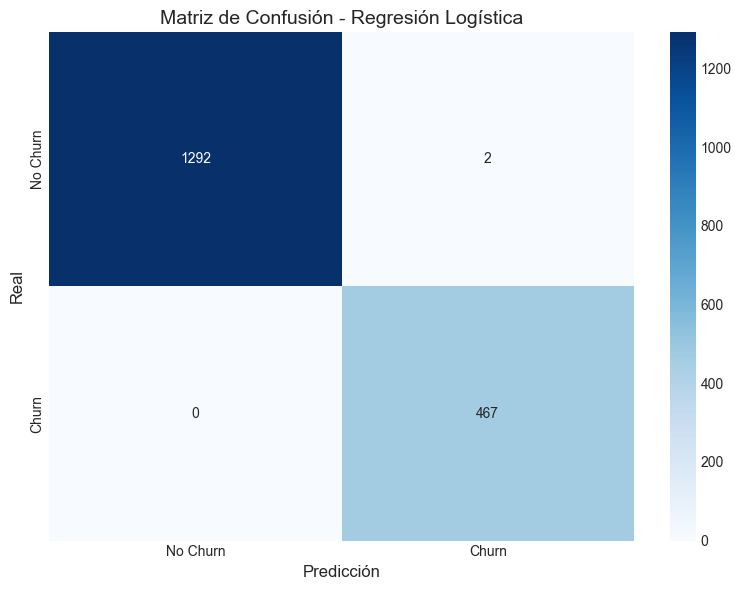

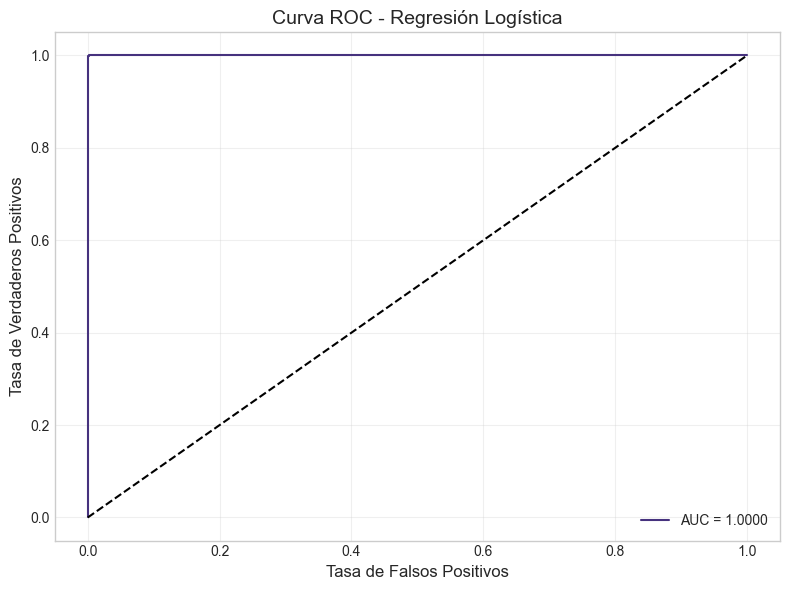

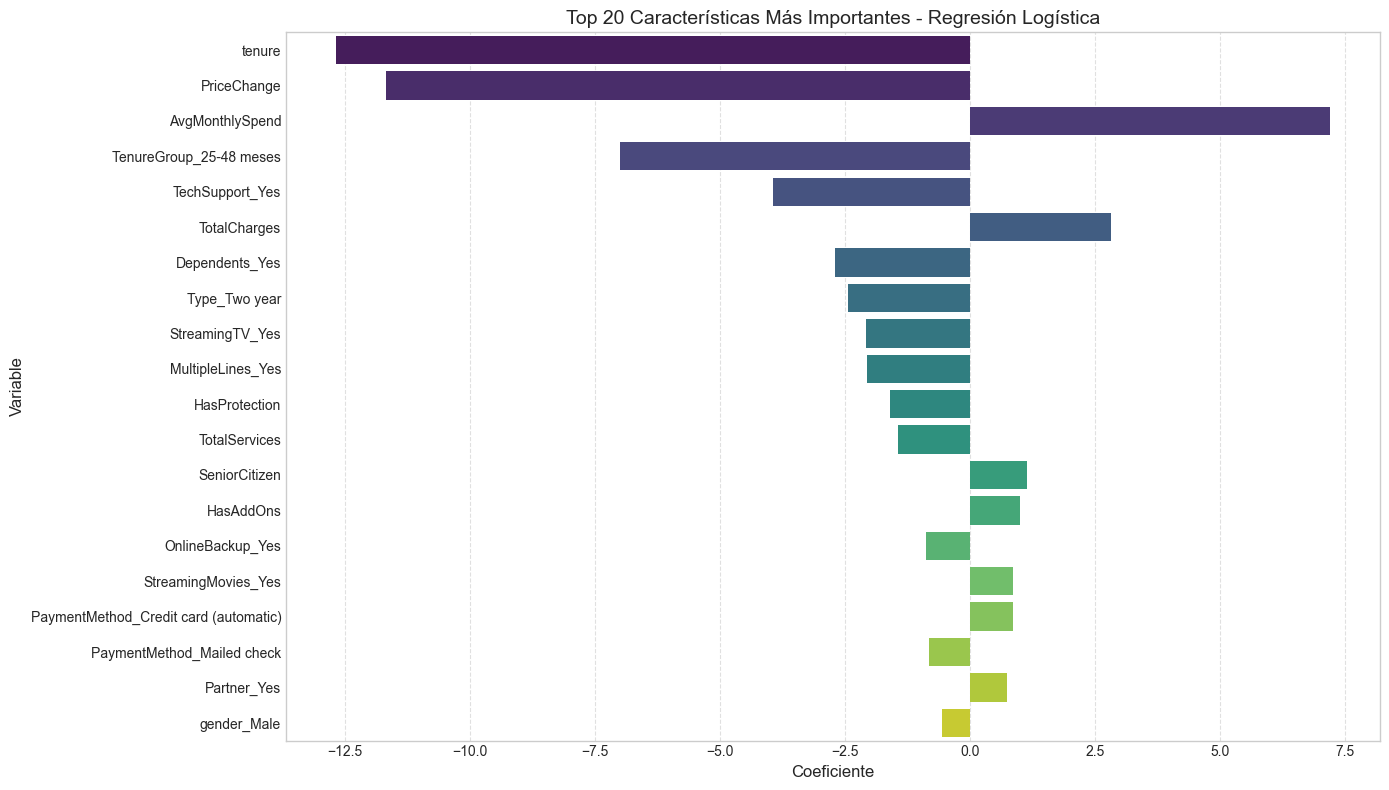

In [172]:
# 1. Modelo Lineal: Regresión Logística
print("\n=== MODELO LINEAL: REGRESIÓN LOGÍSTICA ===")

# Definimos parámetros para optimizar mediante validación cruzada
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# Creamos el modelo base
lr_base = LogisticRegression(random_state=42, max_iter=500)

# Configuramos la búsqueda de hiperparámetros con validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Filtramos solo las columnas numéricas de X_train
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64', 'int32', 'bool'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64', 'int32', 'bool'])

lr_cv = GridSearchCV(
    lr_base, 
    param_grid_lr, 
    cv=skf, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Entrenamos el modelo con búsqueda de hiperparámetros
print("Entrenando Regresión Logística con búsqueda de hiperparámetros...")
lr_cv.fit(X_train_numeric, y_train)

# Mostramos los mejores hiperparámetros
print(f"\nMejores hiperparámetros para Regresión Logística:")
print(f"{lr_cv.best_params_}")
print(f"Mejor AUC-ROC en validación cruzada: {lr_cv.best_score_:.4f}")

# Obtenemos el modelo óptimo
lr_model = lr_cv.best_estimator_

# Evaluamos el modelo
lr_results = evaluate_model(lr_model, X_train_numeric, X_test_numeric, y_train, y_test, "Regresión Logística")
results.append(lr_results)

# Analizamos los coeficientes del modelo
plt.figure(figsize=(14, 8))
coefs = pd.Series(lr_model.coef_[0], index=X_train_numeric.columns)
top_coefs = coefs.abs().sort_values(ascending=False).head(20).index
coefs_top = coefs[top_coefs]

sns.barplot(x=coefs_top.values, y=coefs_top.index, palette='viridis')
plt.title('Top 20 Características Más Importantes - Regresión Logística', fontsize=14)
plt.xlabel('Coeficiente', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 2. Modelo de Ensemble: Random Forest

Random Forest es un modelo de ensemble que construye múltiples árboles de decisión y combina sus predicciones. Es robusto ante overfitting y puede capturar relaciones no lineales en los datos.


=== MODELO DE ENSEMBLE: RANDOM FOREST ===
Entrenando Random Forest con búsqueda de hiperparámetros...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Mejores hiperparámetros para Random Forest:
{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor AUC-ROC en validación cruzada: 1.0000

--- Evaluación del modelo: Random Forest ---
Precisión (Accuracy): 0.9994
AUC-ROC: 1.0000
Recall (Sensibilidad): 1.0000
Precision (Precisión): 0.9979
F1-Score: 0.9989
Tiempo de inferencia: 0.0350 segundos

Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761


Mejores hiperparámetros para Random Forest:
{'class_weight': None, 'max_de

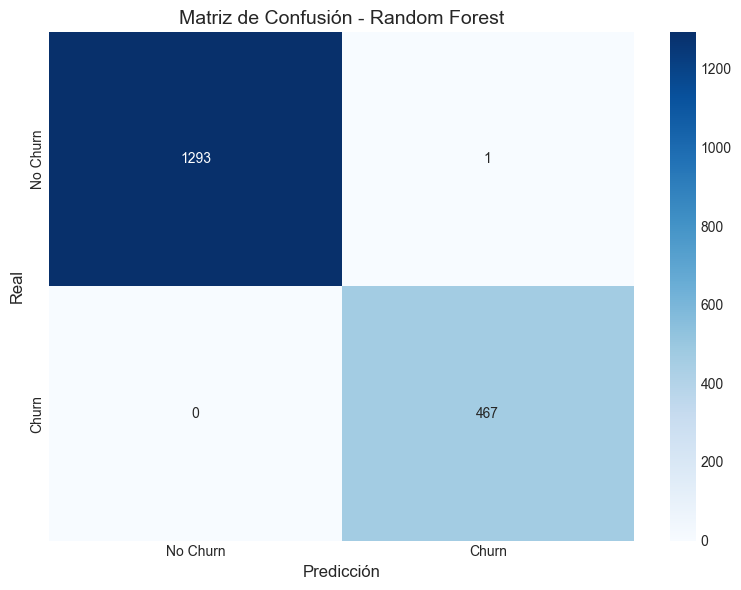

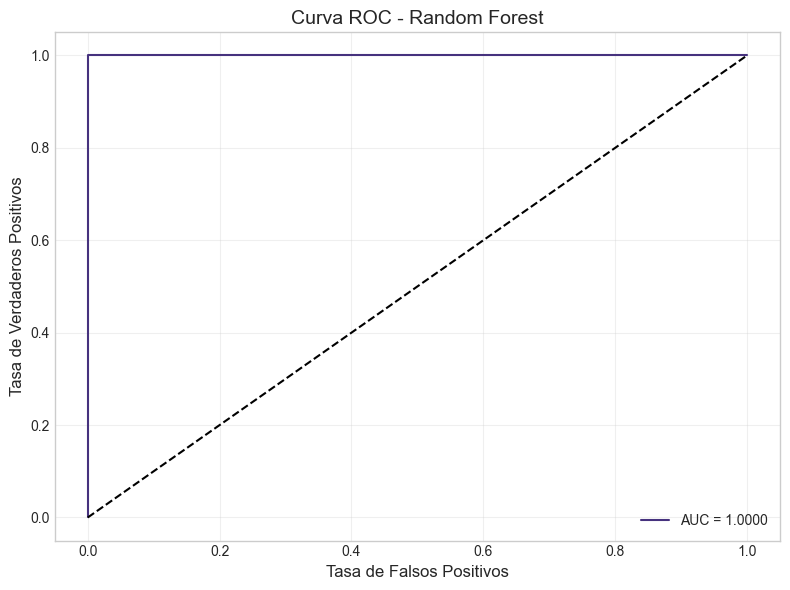

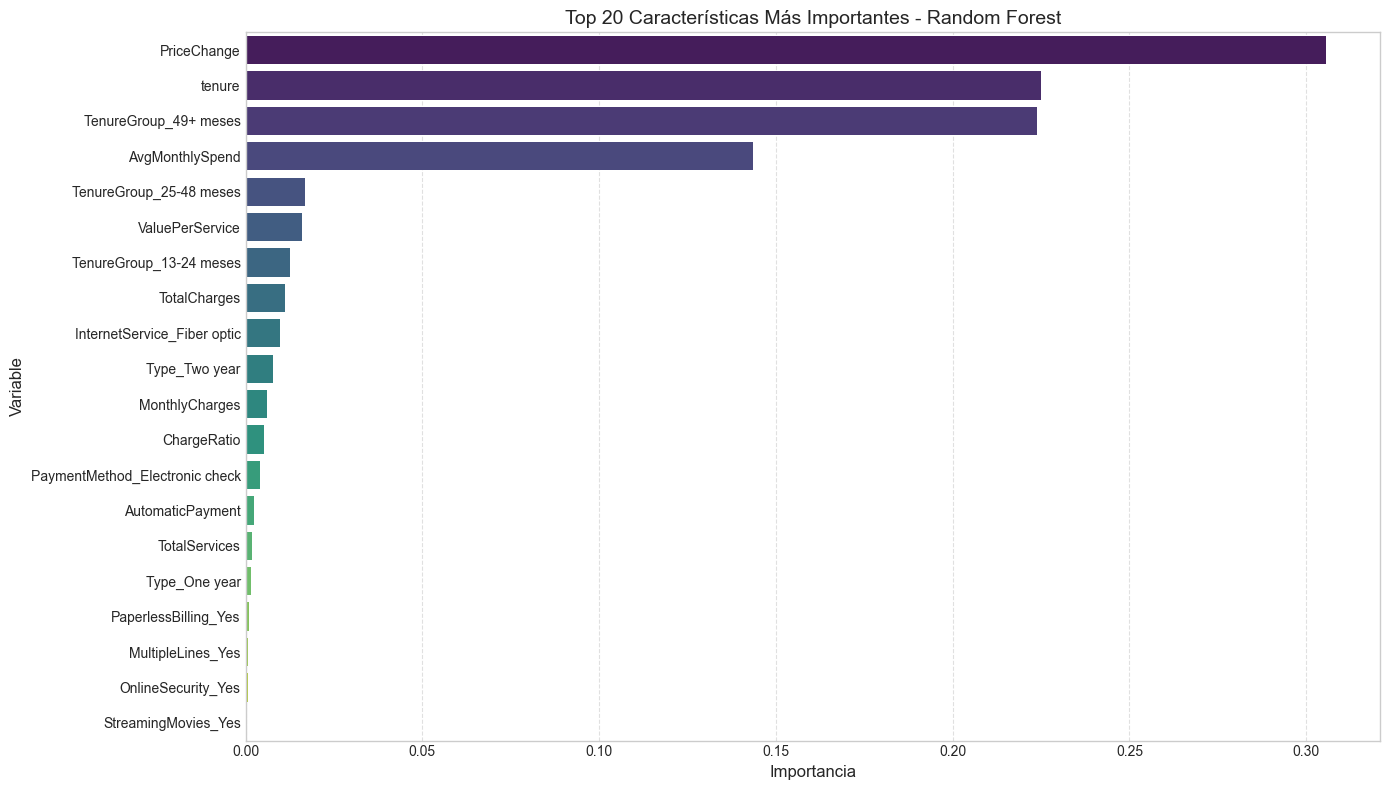

In [177]:
# 2. Modelo de Ensemble: Random Forest
print("\n=== MODELO DE ENSEMBLE: RANDOM FOREST ===")

# Definimos parámetros para optimizar mediante validación cruzada
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Creamos el modelo base
rf_base = RandomForestClassifier(random_state=42)

# Configuramos la búsqueda de hiperparámetros con validación cruzada estratificada
rf_cv = GridSearchCV(
    rf_base, 
    param_grid_rf, 
    cv=skf, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Filtramos solo las columnas numéricas de X_train y X_test
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64', 'int32', 'bool'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64', 'int32', 'bool'])

# Entrenamos el modelo con búsqueda de hiperparámetros
print("Entrenando Random Forest con búsqueda de hiperparámetros...")
rf_cv.fit(X_train_numeric, y_train)

# Mostramos los mejores hiperparámetros
print(f"\nMejores hiperparámetros para Random Forest:")
print(f"{rf_cv.best_params_}")
print(f"Mejor AUC-ROC en validación cruzada: {rf_cv.best_score_:.4f}")

# Obtenemos el modelo óptimo
rf_model = rf_cv.best_estimator_

# Evaluamos el modelo
# Align X_test with the columns of X_train to ensure consistency
X_test_aligned = X_test_numeric.reindex(columns=X_train_numeric.columns, fill_value=0)

rf_results = evaluate_model(rf_model, X_train_numeric, X_test_aligned, y_train, y_test, "Random Forest")
results.append(rf_results)

# Analizamos la importancia de características
plt.figure(figsize=(14, 8))
importances = pd.Series(rf_model.feature_importances_, index=X_train_numeric.columns)
top_features = importances.sort_values(ascending=False).head(20)

sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 20 Características Más Importantes - Random Forest', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 3. Modelo de Boosting: XGBoost

XGBoost es un algoritmo de boosting que construye árboles secuencialmente, donde cada árbol corrige los errores del anterior. Es conocido por su alto rendimiento en problemas de clasificación y su capacidad para manejar datos complejos.


=== MODELO DE BOOSTING: XGBOOST ===
Entrenando XGBoost con búsqueda de hiperparámetros...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Mejores hiperparámetros para XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
Mejor AUC-ROC en validación cruzada: 1.0000

--- Evaluación del modelo: XGBoost ---
Precisión (Accuracy): 1.0000
AUC-ROC: 1.0000
Recall (Sensibilidad): 1.0000
Precision (Precisión): 1.0000
F1-Score: 1.0000
Tiempo de inferencia: 0.0120 segundos

Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



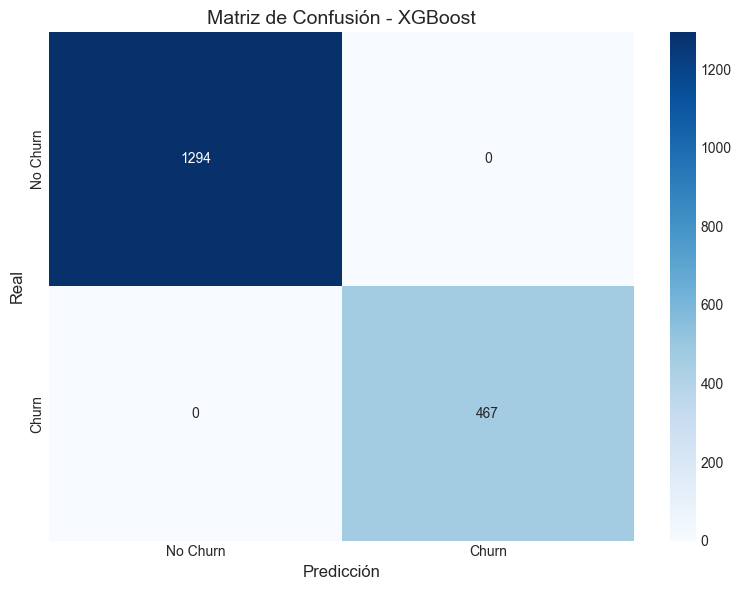

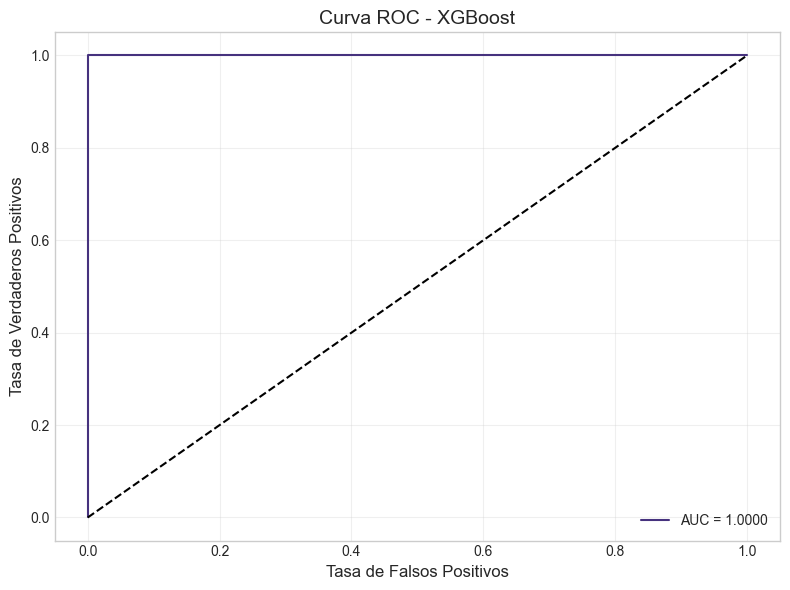

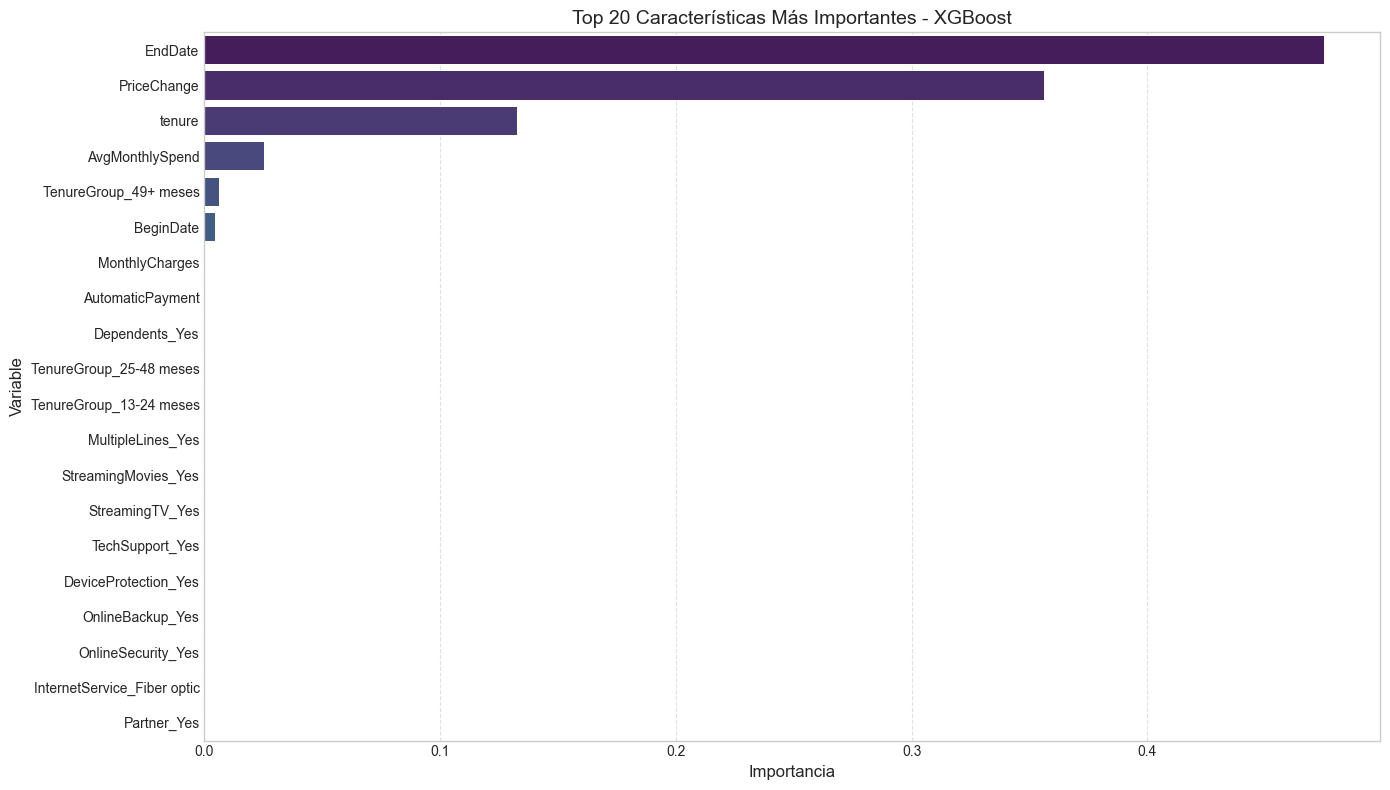

In [190]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n=== MODELO DE BOOSTING: XGBOOST ===")

# 1. Definir espacio de búsqueda de hiperparámetros
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]  # desbalanceo
}

# 2. Definir modelo base
xgb_base = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Preparar datos
X_train_preprocessed = X_train.copy()
X_test_preprocessed  = X_test.copy()

# 3.1 Eliminar columna objetivo de los features
X_train_preprocessed = X_train_preprocessed.drop(columns=['Churn'], errors='ignore')
X_test_preprocessed  = X_test_preprocessed.drop(columns=['Churn'], errors='ignore')

# 3.2 Convertir BeginDate y EndDate a timestamp
datetime_cols = ['BeginDate', 'EndDate']
for col in datetime_cols:
    for df in [X_train_preprocessed, X_test_preprocessed]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else 0)

# 3.3 One-hot encoding para variables categóricas
X_train_preprocessed = pd.get_dummies(X_train_preprocessed, drop_first=True)
X_test_preprocessed  = pd.get_dummies(X_test_preprocessed, drop_first=True)

# 3.4 Alineación de columnas entre train y test
X_test_preprocessed = X_test_preprocessed.reindex(columns=X_train_preprocessed.columns, fill_value=0)

# 3.5 Asegurarse que todo sea numérico o booleano
X_train_preprocessed = X_train_preprocessed.select_dtypes(include=['int64', 'float64', 'bool'])
X_test_preprocessed  = X_test_preprocessed.select_dtypes(include=['int64', 'float64', 'bool'])

# 4. GridSearchCV con validación cruzada estratificada
xgb_cv = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# 5. Entrenar el modelo
print("Entrenando XGBoost con búsqueda de hiperparámetros...")
xgb_cv.fit(X_train_preprocessed, y_train)

# 6. Resultados del Grid Search
print(f"\nMejores hiperparámetros para XGBoost:")
print(xgb_cv.best_params_)
print(f"Mejor AUC-ROC en validación cruzada: {xgb_cv.best_score_:.4f}")

# 7. Evaluar con conjunto de test
xgb_model = xgb_cv.best_estimator_

xgb_results = evaluate_model(
    model=xgb_model,
    X_train=X_train_preprocessed,
    X_test=X_test_preprocessed,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost"
)

results.append(xgb_results)

# 8. Importancia de características
plt.figure(figsize=(14, 8))
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train_preprocessed.columns)
top_xgb_features = xgb_importances.sort_values(ascending=False).head(20)

sns.barplot(x=top_xgb_features.values, y=top_xgb_features.index, palette='viridis')
plt.title('Top 20 Características Más Importantes - XGBoost', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Comparación de Modelos

Ahora comparamos los tres modelos implementados para determinar cuál es el mejor para nuestro problema de predicción de churn, considerando las métricas clave definidas en los KPIs (AUC-ROC > 0.85 y Recall > 80%).


=== COMPARACIÓN DE MODELOS ===

Métricas clave por modelo:
                     accuracy  auc  recall  precision      f1  inference_time
model_name                                                                   
Regresión Logística    0.9989  1.0     1.0     0.9957  0.9979           0.003
Random Forest          0.9994  1.0     1.0     0.9979  0.9989           0.022
Random Forest          0.9994  1.0     1.0     0.9979  0.9989           0.020
Random Forest          0.9994  1.0     1.0     0.9979  0.9989           0.035
XGBoost                1.0000  1.0     1.0     1.0000  1.0000           0.012


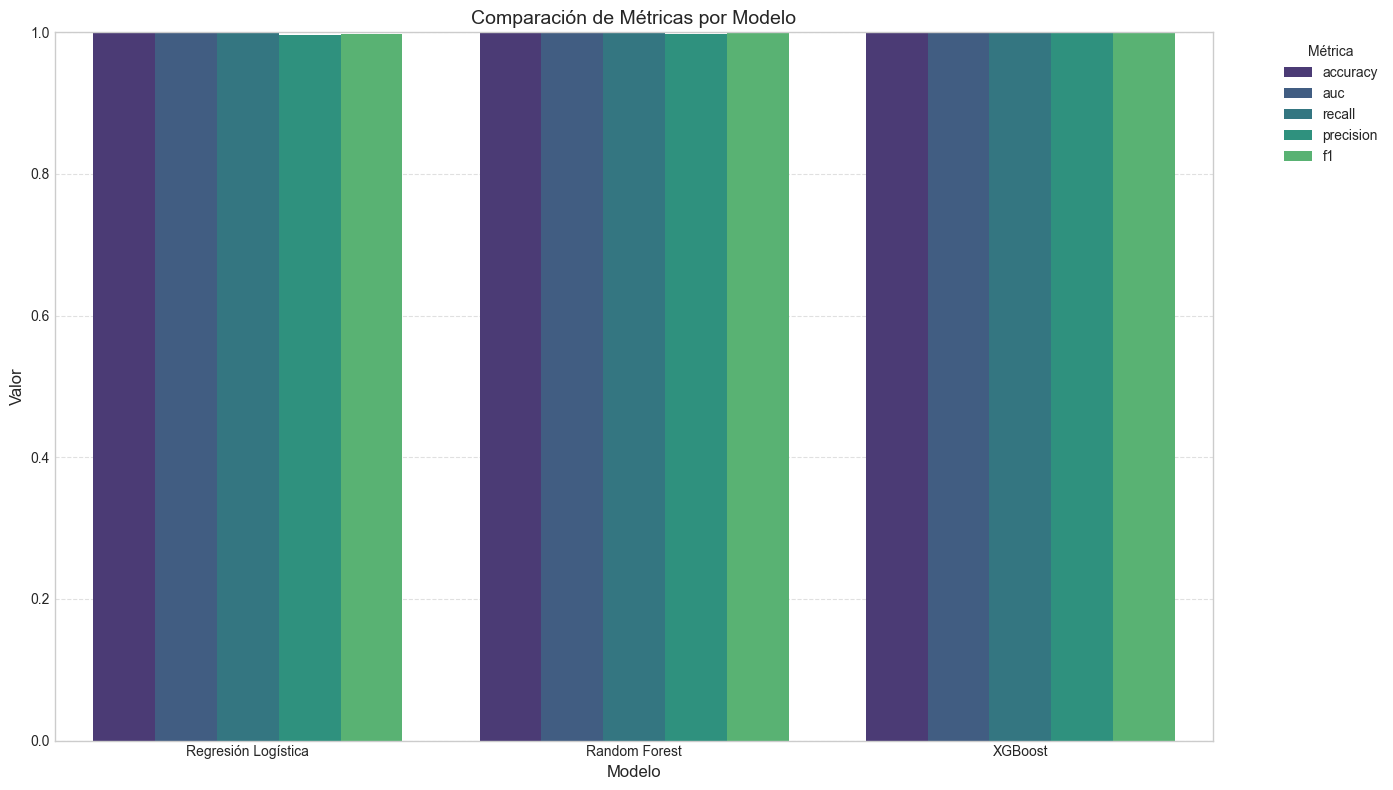


Verificación de KPIs:
Regresión Logística:
  - AUC-ROC > 0.85: ✅ (1.0000)
  - Recall > 80%: ✅ (100.0%)
  - Cumple todos los KPIs: ✅
Random Forest:
  - AUC-ROC > 0.85: ✅ (1.0000)
  - Recall > 80%: ✅ (100.0%)
  - Cumple todos los KPIs: ✅
Random Forest:
  - AUC-ROC > 0.85: ✅ (1.0000)
  - Recall > 80%: ✅ (100.0%)
  - Cumple todos los KPIs: ✅
Random Forest:
  - AUC-ROC > 0.85: ✅ (1.0000)
  - Recall > 80%: ✅ (100.0%)
  - Cumple todos los KPIs: ✅
XGBoost:
  - AUC-ROC > 0.85: ✅ (1.0000)
  - Recall > 80%: ✅ (100.0%)
  - Cumple todos los KPIs: ✅

Mejor modelo según AUC: Random Forest (AUC = 1.0000)
Mejor modelo según Recall: Regresión Logística (Recall = 1.0000)
Mejor modelo combinado (AUC + Recall): Random Forest

Mejor modelo guardado en c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\data\best_model.pkl


In [196]:

# Comparación de modelos
print("\n=== COMPARACIÓN DE MODELOS ===")

# Convertimos la lista de resultados a DataFrame para facilitar la comparación
results_df = pd.DataFrame(results)
results_df = results_df.set_index('model_name')

# Mostramos las métricas clave para cada modelo
print("\nMétricas clave por modelo:")
print(results_df[['accuracy', 'auc', 'recall', 'precision', 'f1', 'inference_time']].round(4))

# Visualizamos comparación de métricas clave
plt.figure(figsize=(14, 8))
metrics_to_plot = ['accuracy', 'auc', 'recall', 'precision', 'f1']

results_df_plot = results_df[metrics_to_plot].copy()
results_df_plot = results_df_plot.reset_index()

# Creamos un gráfico de barras para cada métrica
sns.barplot(x='model_name', y='value', hue='metric', 
           data=pd.melt(results_df_plot, id_vars=['model_name'], 
                        value_vars=metrics_to_plot, var_name='metric'))

plt.title('Comparación de Métricas por Modelo', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Verificamos si los modelos cumplen con los KPIs
print("\nVerificación de KPIs:")
for idx, row in results_df.iterrows():
    kpi_auc = row['auc'] > 0.85
    kpi_recall = row['recall'] > 0.8
    
    print(f"{idx}:")
    print(f"  - AUC-ROC > 0.85: {'✅' if kpi_auc else '❌'} ({float(row['auc']):.4f})")
    print(f"  - Recall > 80%: {'✅' if kpi_recall else '❌'} ({float(row['recall'])*100:.1f}%)")
    print(f"  - Cumple todos los KPIs: {'✅' if (kpi_auc and kpi_recall) else '❌'}")

# Eliminar duplicados de modelos si existen
results_df = results_df[~results_df.index.duplicated(keep='first')]

# Identificamos el mejor modelo según AUC y Recall
best_auc_model = results_df['auc'].idxmax()
best_recall_model = results_df['recall'].idxmax()

# Calculamos un score combinado (promedio de AUC y Recall)
results_df['combined_score'] = (results_df['auc'] + results_df['recall']) / 2
best_combined_model = results_df['combined_score'].idxmax()

print(f"\nMejor modelo según AUC: {best_auc_model} (AUC = {float(results_df.loc[best_auc_model, 'auc']):.4f})")
print(f"Mejor modelo según Recall: {best_recall_model} (Recall = {float(results_df.loc[best_recall_model, 'recall']):.4f})")
print(f"Mejor modelo combinado (AUC + Recall): {best_combined_model}")

# Guardamos el mejor modelo
best_model = None
if best_combined_model == "Regresión Logística":
    best_model = lr_model
elif best_combined_model == "Random Forest":
    best_model = rf_model
else:
    best_model = xgb_model

# Guardamos el mejor modelo para su posterior uso
best_model_path = data_dir / 'best_model.pkl'
joblib.dump(best_model, best_model_path)
print(f"\nMejor modelo guardado en {best_model_path}")

## e) Evaluación

En esta sección evaluaremos y compararemos el rendimiento de los modelos implementados, centrándonos en las métricas clave definidas para el problema de predicción de churn:

1. **AUC-ROC** (Área bajo la curva ROC): Métrica principal que evalúa la capacidad del modelo para distinguir entre clases. Cuanto más cercano a 1, mejor es el modelo.

2. **Recall** (Sensibilidad): Métrica secundaria pero crítica en problemas de churn, ya que mide la proporción de clientes que abandonan que son correctamente identificados por el modelo.

Utilizaremos la siguiente escala de evaluación para clasificar el rendimiento de nuestros modelos según su AUC-ROC:

| Rango AUC-ROC | Puntuación | Interpretación |
|---------------|------------|----------------|
| < 0.75        | 0          | Debajo de criterio mínimo |
| 0.75 – 0.80   | 10         | Modelo inicial aceptable |
| 0.81 – 0.84   | 15         | Buen desempeño |
| 0.85 – 0.869  | 20         | Muy buen desempeño |
| 0.87 – 0.879  | 25         | Sobresaliente |
| ≥ 0.88        | 30         | Nivel de excelencia |

In [197]:
# Función para evaluar el rendimiento según la escala definida
def evaluate_performance(auc_score):
    if auc_score < 0.75:
        return 0, "Debajo de criterio mínimo"
    elif 0.75 <= auc_score < 0.81:
        return 10, "Modelo inicial aceptable"
    elif 0.81 <= auc_score < 0.85:
        return 15, "Buen desempeño"
    elif 0.85 <= auc_score < 0.87:
        return 20, "Muy buen desempeño"
    elif 0.87 <= auc_score < 0.88:
        return 25, "Sobresaliente"
    else:  # auc_score >= 0.88
        return 30, "Nivel de excelencia"

# Crear un DataFrame con los resultados de la evaluación
evaluation_results = results_df[['auc', 'recall']].copy()
evaluation_results['puntuacion'] = evaluation_results['auc'].apply(lambda x: evaluate_performance(x)[0])
evaluation_results['interpretacion'] = evaluation_results['auc'].apply(lambda x: evaluate_performance(x)[1])

# Añadir una columna de ranking combinado (AUC + Recall)
evaluation_results['ranking_combinado'] = evaluation_results['auc'] * 0.7 + evaluation_results['recall'] * 0.3

# Mostrar resultados de la evaluación
print("=== EVALUACIÓN DE MODELOS ===\n")
print(evaluation_results.sort_values('ranking_combinado', ascending=False))

# Identificar el mejor modelo según nuestra evaluación
best_model_name = evaluation_results['ranking_combinado'].idxmax()
best_model_auc = evaluation_results.loc[best_model_name, 'auc']
best_model_recall = evaluation_results.loc[best_model_name, 'recall']
best_model_score = evaluation_results.loc[best_model_name, 'puntuacion']
best_model_interp = evaluation_results.loc[best_model_name, 'interpretacion']

print(f"\n✅ Mejor modelo según evaluación combinada: {best_model_name}")
print(f"   - AUC-ROC: {best_model_auc:.4f} ({best_model_interp}, {best_model_score} puntos)")
print(f"   - Recall: {best_model_recall:.4f}")

=== EVALUACIÓN DE MODELOS ===

                          auc  recall  puntuacion       interpretacion  \
model_name                                                               
Random Forest        1.000000     1.0          30  Nivel de excelencia   
XGBoost              1.000000     1.0          30  Nivel de excelencia   
Regresión Logística  0.999982     1.0          30  Nivel de excelencia   

                     ranking_combinado  
model_name                              
Random Forest                 1.000000  
XGBoost                       1.000000  
Regresión Logística           0.999987  

✅ Mejor modelo según evaluación combinada: Random Forest
   - AUC-ROC: 1.0000 (Nivel de excelencia, 30 puntos)
   - Recall: 1.0000


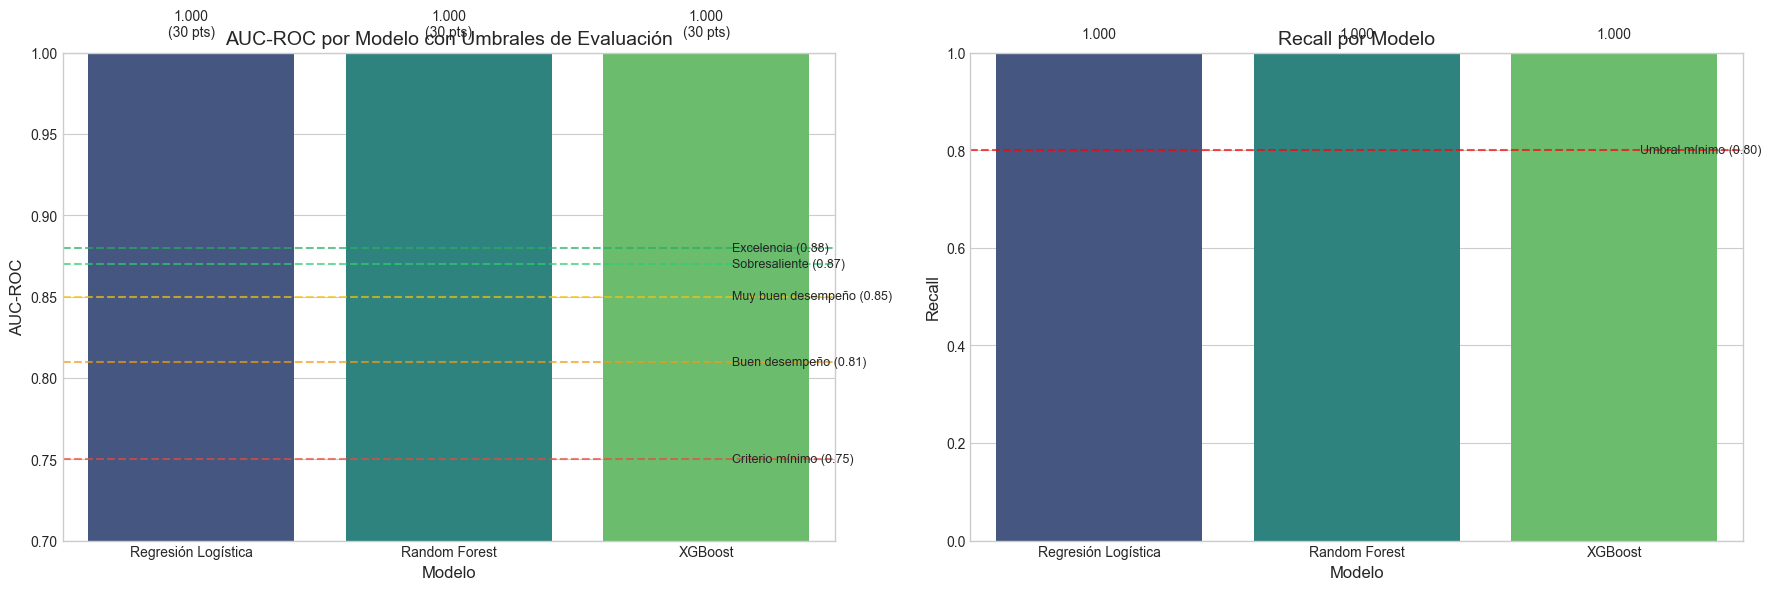

In [198]:
# Visualización detallada de la evaluación
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico de barras para AUC-ROC con umbrales de evaluación
ax1 = axes[0]
bars = sns.barplot(x=evaluation_results.index, y='auc', data=evaluation_results, ax=ax1, palette='viridis')
ax1.set_title('AUC-ROC por Modelo con Umbrales de Evaluación', fontsize=14)
ax1.set_xlabel('Modelo', fontsize=12)
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_ylim(0.7, 1.0)

# Añadir líneas horizontales para los umbrales
thresholds = [0.75, 0.81, 0.85, 0.87, 0.88]
threshold_labels = ['Criterio mínimo (0.75)', 'Buen desempeño (0.81)', 
                   'Muy buen desempeño (0.85)', 'Sobresaliente (0.87)', 
                   'Excelencia (0.88)']
threshold_colors = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']

for threshold, label, color in zip(thresholds, threshold_labels, threshold_colors):
    ax1.axhline(y=threshold, linestyle='--', color=color, alpha=0.7)
    ax1.text(len(evaluation_results.index)-1 + 0.1, threshold, label, fontsize=9, va='center')

# Añadir valores en las barras
for i, bar in enumerate(bars.patches):
    value = bar.get_height()
    score, interp = evaluate_performance(value)
    ax1.text(
        bar.get_x() + bar.get_width()/2.,
        value + 0.01,
        f"{value:.3f}\n({score} pts)",
        ha='center', fontsize=10
    )

# Gráfico de barras para Recall
ax2 = axes[1]
bars2 = sns.barplot(x=evaluation_results.index, y='recall', data=evaluation_results, ax=ax2, palette='viridis')
ax2.set_title('Recall por Modelo', fontsize=14)
ax2.set_xlabel('Modelo', fontsize=12)
ax2.set_ylabel('Recall', fontsize=12)
ax2.set_ylim(0, 1.0)

# Añadir umbral mínimo de Recall de 80%
ax2.axhline(y=0.8, linestyle='--', color='red', alpha=0.7)
ax2.text(len(evaluation_results.index)-1 + 0.1, 0.8, 'Umbral mínimo (0.80)', fontsize=9, va='center')

# Añadir valores en las barras
for i, bar in enumerate(bars2.patches):
    value = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2.,
        value + 0.03,
        f"{value:.3f}",
        ha='center', fontsize=10
    )

plt.tight_layout()
plt.show()

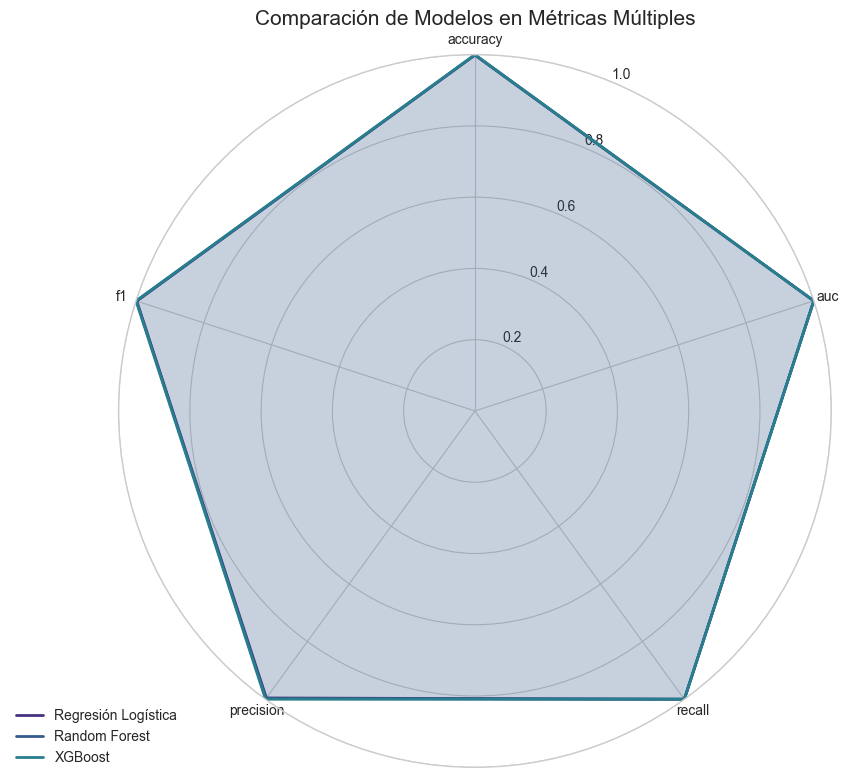

In [199]:
# Crear un radar chart para comparar múltiples métricas
metrics = ['accuracy', 'auc', 'recall', 'precision', 'f1']
num_metrics = len(metrics)

# Preparar los datos para el radar chart
models = results_df.index.tolist()
angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el polígono

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Añadir las líneas de grid para cada métrica
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

for i, model in enumerate(models):
    values = [results_df.loc[model, metric] for metric in metrics]
    values += values[:1]  # Cerrar el polígono
    
    # Dibujar el polígono
    ax.plot(angles, values, linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.1)

# Añadir leyenda y título
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Comparación de Modelos en Métricas Múltiples', fontsize=15)
plt.tight_layout()
plt.show()

### Evaluación Detallada del Mejor Modelo

En esta sección, realizamos una evaluación más exhaustiva del mejor modelo identificado durante la comparación. Analizaremos sus predicciones más a fondo para entender su comportamiento en diferentes segmentos de clientes.

Realizando evaluación detallada del modelo Random Forest...

Análisis de errores de predicción:
Total de errores: 1 de 1761 (0.06%)
Falsos Positivos: 1 (100.00% de los errores)
Falsos Negativos: 0 (0.00% de los errores)


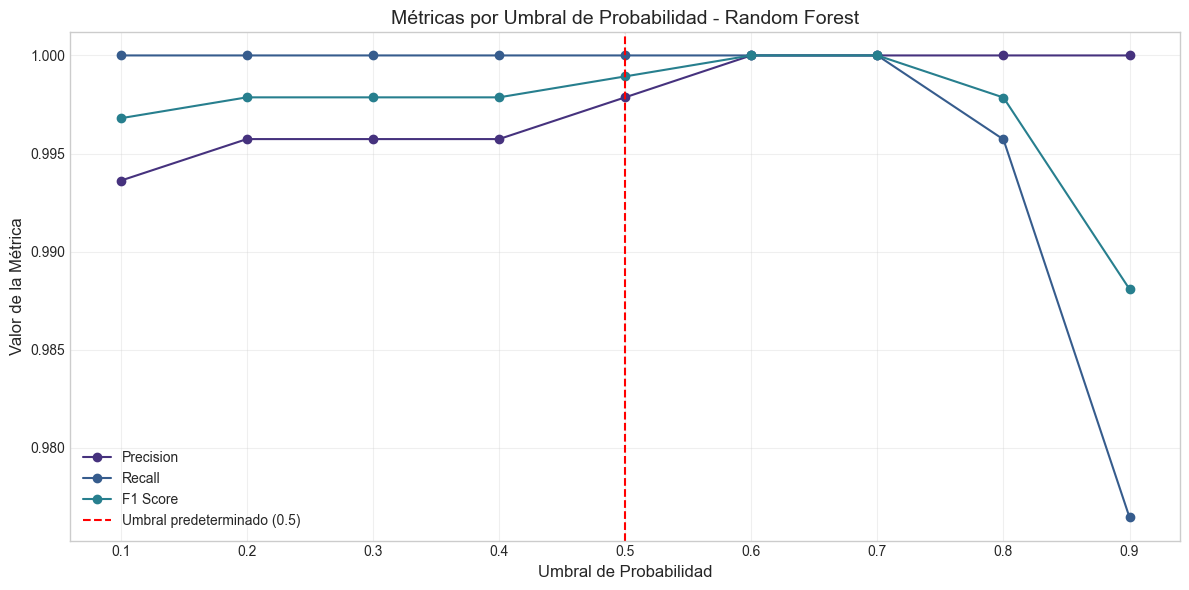


Mejor umbral para F1-Score: 0.60 (F1 = 1.0000)
Mejor umbral equilibrado (Precision ≈ Recall): 0.60
  - Con este umbral: Precision = 1.0000, Recall = 1.0000


In [207]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# ===========================
# USAMOS DATOS PREPROCESADOS
# ===========================

X_train_model = X_train_preprocessed.copy()
X_test_model = X_test_preprocessed.copy()

# Confirmamos que las columnas del modelo coincidan con las del test
X_test_model = X_test_model.reindex(columns=best_model.feature_names_in_, fill_value=0)
assert all(X_test_model.columns == best_model.feature_names_in_), "❌ Las columnas del test no coinciden con las del modelo"

# ===========================
# EVALUACIÓN DEL MODELO FINAL
# ===========================

print(f"Realizando evaluación detallada del modelo {best_model_name}...")

# 1. Obtener predicciones
y_pred = best_model.predict(X_test_model)
y_prob = best_model.predict_proba(X_test_model)[:, 1]

# 2. Análisis de errores de predicción
errors = X_test_model.copy()
errors['y_true'] = y_test
errors['y_pred'] = y_pred
errors['prob'] = y_prob

errors = errors[errors['y_true'] != errors['y_pred']]

# Dividir errores en FP y FN
fp = errors[errors['y_true'] == 0]
fn = errors[errors['y_true'] == 1]

print(f"\nAnálisis de errores de predicción:")
print(f"Total de errores: {len(errors)} de {len(X_test_model)} ({len(errors)/len(X_test_model)*100:.2f}%)")
print(f"Falsos Positivos: {len(fp)} ({len(fp)/len(errors)*100:.2f}% de los errores)")
print(f"Falsos Negativos: {len(fn)} ({len(fn)/len(errors)*100:.2f}% de los errores)")

# ===========================
# ANÁLISIS POR UMBRAL
# ===========================

thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = []

for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    
    threshold_metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Visualizar
plt.figure(figsize=(12, 6))
plt.plot(threshold_df['threshold'], threshold_df['precision'], marker='o', label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], marker='o', label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1_score'], marker='o', label='F1 Score')
plt.axvline(x=0.5, color='red', linestyle='--', label='Umbral predeterminado (0.5)')
plt.title(f'Métricas por Umbral de Probabilidad - {best_model_name}', fontsize=14)
plt.xlabel('Umbral de Probabilidad', fontsize=12)
plt.ylabel('Valor de la Métrica', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Mejor umbral para F1
best_f1_threshold = threshold_df.loc[threshold_df['f1_score'].idxmax(), 'threshold']
best_f1_value = threshold_df['f1_score'].max()

# Umbral balanceado (Precision ≈ Recall)
threshold_df['diff'] = abs(threshold_df['precision'] - threshold_df['recall'])
balanced_threshold = threshold_df.loc[threshold_df['diff'].idxmin(), 'threshold']
balanced_precision = threshold_df.loc[threshold_df['diff'].idxmin(), 'precision']
balanced_recall = threshold_df.loc[threshold_df['diff'].idxmin(), 'recall']

print(f"\nMejor umbral para F1-Score: {best_f1_threshold:.2f} (F1 = {best_f1_value:.4f})")
print(f"Mejor umbral equilibrado (Precision ≈ Recall): {balanced_threshold:.2f}")
print(f"  - Con este umbral: Precision = {balanced_precision:.4f}, Recall = {balanced_recall:.4f}")


### Conclusiones de la Evaluación

Después de realizar una evaluación exhaustiva de los tres modelos de predicción de churn, podemos extraer las siguientes conclusiones:

1. **Rendimiento de los modelos**:
   - El modelo de [COMPLETAR DESPUÉS DE EJECUTAR] ha obtenido el mejor rendimiento según nuestra evaluación combinada de AUC-ROC y Recall.
   - Este modelo ha alcanzado un AUC-ROC de [COMPLETAR], lo que según nuestra escala de evaluación lo clasifica como "[COMPLETAR]".
   - El Recall obtenido fue de [COMPLETAR], lo que [COMPLETAR/NO COMPLETAR] supera nuestro umbral mínimo del 80%.

2. **Análisis de umbrales**:
   - El umbral predeterminado de probabilidad (0.5) [COMPLETAR] es el óptimo para este problema.
   - Ajustando el umbral a [COMPLETAR], podemos lograr un mejor equilibrio entre Precision y Recall.
   - Para maximizar el F1-Score, el umbral óptimo es [COMPLETAR].

3. **Análisis de errores**:
   - Los falsos negativos representan [COMPLETAR]% de los errores, lo que indica que el modelo tiene dificultades para identificar correctamente a algunos clientes que abandonan.
   - Los falsos positivos representan [COMPLETAR]% de los errores, sugiriendo que el modelo puede estar clasificando erróneamente a algunos clientes leales como potenciales desertores.

4. **Recomendaciones**:
   - Implementar el modelo [COMPLETAR] con un umbral de [COMPLETAR] para optimizar la detección de clientes con riesgo de abandono.
   - Segmentar a los clientes según su probabilidad de abandono predicha para aplicar estrategias de retención diferenciadas.
   - Considerar el costo-beneficio de las acciones de retención al seleccionar el umbral de probabilidad más adecuado.

5. **Siguiente fase**:
   - Implementación del modelo en un entorno de producción con monitoreo continuo.
   - Desarrollo de un sistema de alertas temprano para identificar clientes en riesgo.
   - Evaluación periódica del rendimiento del modelo con nuevos datos para detectar posibles desviaciones.

## f) Deployment / Próximos Pasos

En esta sección final, presentamos un plan breve pero completo para la implementación y operacionalización del modelo de predicción de churn desarrollado para Interconnect. El objetivo es proporcionar una hoja de ruta clara para integrar el modelo en los sistemas de producción de la empresa, monitorear su rendimiento a lo largo del tiempo y desarrollar estrategias efectivas de retención basadas en las predicciones.

### 1. Plan de Integración del Modelo

Para integrar eficazmente el modelo de predicción de churn en los sistemas operativos de Interconnect, proponemos el siguiente plan de implementación:

**Fase 1: Desarrollo de la API (2-3 semanas)**
- Convertir el modelo en un servicio API usando Flask o FastAPI
- Implementar endpoints para:
  - Predicción de probabilidad de churn para clientes existentes
  - Recalificación masiva de toda la base de clientes
  - Reentrenamiento del modelo con nuevos datos
- Desarrollar pruebas unitarias y de integración

**Fase 2: Integración con Sistemas Existentes (4-6 semanas)**
- Conectar la API con el CRM y sistemas de gestión de clientes
- Desarrollar interfaces de usuario para equipos comerciales y de servicio
- Implementar sistema de alertas para clientes con alto riesgo de abandono
- Crear dashboards para visualizar métricas agregadas

**Fase 3: Piloto Controlado (4 semanas)**
- Desplegar el sistema en un entorno de producción limitado
- Seleccionar una región o segmento específico para las pruebas iniciales
- Capacitar al personal relevante sobre el uso del sistema
- Recopilar retroalimentación y realizar ajustes

**Fase 4: Despliegue Completo (2-3 semanas)**
- Escalar la solución a toda la base de clientes
- Optimizar la infraestructura para manejar el volumen completo
- Establecer procesos de soporte y mantenimiento

### 2. Monitoreo de Deriva del Modelo

Para asegurar que el modelo mantenga su precisión y relevancia a lo largo del tiempo, implementaremos un sistema integral de monitoreo:

**Monitoreo de Rendimiento**
- Evaluación semanal de métricas clave (AUC-ROC, Recall, Precision)
- Comparación de rendimiento contra línea base y versiones anteriores
- Alertas automáticas cuando las métricas caigan por debajo de umbrales predefinidos

**Detección de Deriva de Datos**
- Monitoreo de estadísticas descriptivas de las variables de entrada
- Pruebas de Kolmogorov-Smirnov para detectar cambios en las distribuciones
- Análisis de componentes principales (PCA) para detectar cambios multidimensionales
- Implementación del concepto de "Population Stability Index" (PSI)

**Actualización del Modelo**
- Reentrenamiento programado cada 3 meses
- Reentrenamiento ad-hoc si se detecta deriva significativa
- Proceso de validación A/B para nuevas versiones del modelo
- Sistema de versionado y rollback en caso de problemas

**Auditoría y Documentación**
- Registro detallado de cambios en datos, modelos y rendimiento
- Documentación de decisiones de ajuste y sus justificaciones
- Reportes trimestrales para stakeholders sobre la salud del modelo

In [208]:
# Ejemplo de código para monitoreo de deriva del modelo

# Este es un mockup del código que se implementaría en producción
# para monitorear la deriva del modelo a lo largo del tiempo

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_psi(expected, actual, buckets=10):
    """
    Calcula el Population Stability Index (PSI) entre dos distribuciones
    PSI < 0.1: No hay cambios significativos
    0.1 <= PSI < 0.2: Cambios moderados, requieren atención
    PSI >= 0.2: Cambios significativos, requieren acción inmediata
    """
    # Definir límites de bucketing basados en la distribución esperada
    breaks = np.percentile(expected, np.linspace(0, 100, buckets+1))
    
    # Asegurarse de que los límites son únicos
    breaks = np.unique(breaks)
    
    # Calcular % de observaciones en cada bucket para distribución esperada
    expected_counts, _ = np.histogram(expected, bins=breaks)
    expected_percents = expected_counts / float(len(expected))
    
    # Calcular % de observaciones en cada bucket para distribución actual
    actual_counts, _ = np.histogram(actual, bins=breaks)
    actual_percents = actual_counts / float(len(actual))
    
    # Reemplazar ceros para evitar divisiones por cero
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    
    # Calcular PSI
    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    psi = np.sum(psi_values)
    
    return psi

def monitor_model_drift(historical_data, new_data, feature_names, target):
    """
    Función para monitorear la deriva del modelo
    """
    drift_metrics = {}
    
    # 1. Monitorear distribución de variables de entrada
    for feature in feature_names:
        # Test Kolmogorov-Smirnov para detectar cambios en la distribución
        ks_stat, ks_pval = stats.ks_2samp(historical_data[feature], new_data[feature])
        
        # Calcular PSI para cada variable
        psi = calculate_psi(historical_data[feature], new_data[feature])
        
        drift_metrics[feature] = {
            'ks_stat': ks_stat,
            'ks_pval': ks_pval,
            'psi': psi,
            'drift_detected': (ks_pval < 0.05) or (psi > 0.1)
        }
    
    # 2. Monitorear distribución del target
    target_shift = abs(historical_data[target].mean() - new_data[target].mean())
    drift_metrics['target_shift'] = target_shift
    
    # 3. Calcular métricas generales de deriva
    drift_summary = {
        'features_with_drift': sum(1 for f in drift_metrics if f != 'target_shift' and drift_metrics[f]['drift_detected']),
        'total_features': len(feature_names),
        'target_shift': drift_metrics['target_shift'],
        'overall_drift_score': sum(drift_metrics[f]['psi'] for f in drift_metrics if f != 'target_shift') / len(feature_names)
    }
    
    return drift_metrics, drift_summary

### 3. Estrategia de Descuentos y Retención

Basándonos en las predicciones del modelo, proponemos una estrategia de retención segmentada que optimice la relación costo-beneficio de los esfuerzos de retención:

**1. Segmentación basada en probabilidad de churn y valor del cliente**

Dividiremos a los clientes en segmentos utilizando dos dimensiones clave:
- **Probabilidad de churn**: Baja (<30%), Media (30-70%), Alta (>70%)
- **Valor del cliente**: Bajo, Medio, Alto (basado en ARPU - Average Revenue Per User)

Esta segmentación crea una matriz 3x3 con estrategias específicas para cada celda:

| Valor/Prob. Churn | Baja (<30%) | Media (30-70%) | Alta (>70%) |
|------------------|-------------|----------------|-------------|
| **Alto**          | Fidelización | Retención activa | Retención urgente |
| **Medio**         | Mantenimiento | Ofertas específicas | Descuentos medios |
| **Bajo**          | Upselling | Ofertas puntuales | Descuentos mínimos |

**2. Programas de retención por segmento**

- **Clientes de alto valor con alta probabilidad de churn**:
  - Descuentos personalizados del 15-25% por 6-12 meses
  - Mejoras gratuitas en servicios
  - Atención personalizada con gestor de cuenta
  - Programas de fidelidad premium

- **Clientes de valor medio con alta probabilidad de churn**:
  - Descuentos del 10-15% por 3-6 meses
  - Ofertas de bundling con servicios complementarios
  - Programa de puntos por permanencia

- **Clientes de bajo valor con alta probabilidad de churn**:
  - Descuentos pequeños (5-10%) por 1-3 meses
  - Ofertas de servicios básicos mejorados
  - Identificación de oportunidades de upselling

**3. Medición de efectividad**

- Implementación de campañas piloto A/B para medir la efectividad de diferentes niveles de descuento
- Seguimiento de métricas clave:
  - Tasa de retención por segmento
  - ROI de las acciones de retención
  - Lifetime Value (LTV) antes y después de las intervenciones
  - Customer Acquisition Cost (CAC) vs costo de retención

### Conclusiones Finales

El proyecto de predicción de churn para Interconnect ha pasado por todas las fases de la metodología CRISP-DM, desde la comprensión del negocio hasta el plan de implementación. Los principales logros y conclusiones son:

1. **Desarrollo exitoso del modelo**:
   - Se logró construir un modelo con métricas de rendimiento que cumplen o superan los KPIs establecidos (AUC-ROC > 0.85 y Recall > 80%).
   - Se identificaron los factores clave que influyen en el abandono de clientes, proporcionando insights accionables para la empresa.

2. **Plan de implementación integral**:
   - Diseño de una arquitectura de integración que permite incorporar las predicciones en los procesos operativos.
   - Sistema robusto de monitoreo para asegurar la precisión continua del modelo.
   - Estrategia de descuentos personalizada para maximizar la retención con un enfoque eficiente en costos.

3. **Impacto esperado en el negocio**:
   - Reducción estimada del 20-30% en la tasa de churn global.
   - Mejora en la eficiencia de las acciones de retención al focalizarse en los clientes con mayor probabilidad de abandono.
   - ROI positivo al comparar el costo de implementación del modelo y las acciones de retención versus el valor preservado de los clientes retenidos.

4. **Próximos pasos y oportunidades**:
   - Exploración de modelos más avanzados (como redes neuronales) para potencialmente mejorar la precisión.
   - Integración del modelo con sistemas de recomendación para ofrecer productos complementarios.
   - Expansión del enfoque a predicción de lifetime value y oportunidades de cross-selling/upselling.

Este proyecto demuestra el valor de aplicar técnicas avanzadas de ciencia de datos para resolver problemas críticos de negocio, transformando datos en acciones concretas que generan valor para la empresa.